In [2]:
import laspy
import lazrs
import laszip
from pyproj import Proj, transform

# ALS

In [2]:
laspy.LazBackend.detect_available()

(<LazBackend.LazrsParallel: 0>, <LazBackend.Lazrs: 1>, <LazBackend.Laszip: 2>)

In [134]:
las = laspy.read('las/NEON_D01_BART_DP1_313000_4881000_classified_point_cloud_colorized.las')

In [58]:
for k in las.header.__dict__.keys():
    print(k)

file_source_id
global_encoding
uuid
_version
system_identifier
generating_software
_point_format
creation_date
point_count
scales
offsets
maxs
mins
number_of_points_by_return
_vlrs
extra_header_bytes
extra_vlr_bytes
start_of_waveform_data_packet_record
start_of_first_evlr
number_of_evlrs
evlrs
offset_to_point_data
are_points_compressed


In [59]:
for dimension in las.point_format.dimensions:
    print(dimension.name)

X
Y
Z
intensity
return_number
number_of_returns
scan_direction_flag
edge_of_flight_line
classification
synthetic
key_point
withheld
scan_angle_rank
user_data
point_source_id
gps_time
red
green
blue


In [37]:
las1.header.min

array([ 313000., 4881000.,       0.])

In [36]:
las1.header.max

array([3.13999990e+05, 4.88199999e+06, 4.03100000e+01])

In [23]:
utm_proj = Proj(proj='utm', zone=19, datum='WGS84', north=True)
wgs84_proj = Proj(proj='latlong', datum='WGS84')

In [54]:
easting = 414600  
northing = 4581600  

lon, lat = transform(utm_proj, wgs84_proj, easting, northing)
print(f'{lon:.06f}, {lat:.06f}')

-70.021342, 41.381394


/tmp/ipykernel_177888/1872833413.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(utm_proj, wgs84_proj, easting, northing)


In [55]:
easting = 415199.98999  
northing = 4582199.9900  

lon, lat = transform(utm_proj, wgs84_proj, easting, northing)
print(f'{lon:.06f}, {lat:.06f}')

-70.014252, 41.386861


/tmp/ipykernel_177888/2043989478.py:4: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(utm_proj, wgs84_proj, easting, northing)


In [72]:
# Check the VLRs (Variable Length Records)
for vlr in las.vlrs:
    print(f"VLR User ID: {vlr.user_id}")
    print(f"VLR Record ID: {vlr.record_id}")
    print(f"VLR Description: {vlr.description}")
    print(f"VLR Data: {vlr.record_data}")
    print("-" * 40)

# Check the EVLRs (Extended Variable Length Records)
for evlr in las.evlrs:
    print(f"EVLR User ID: {evlr.user_id}")
    print(f"EVLR Record ID: {evlr.record_id}")
    print(f"EVLR Description: {evlr.description}")
    # print(f"EVLR Data: {evlr.record_data}")
    print("-" * 40)

VLR User ID: LASF_Projection
VLR Record ID: 34735
VLR Description: by LAStools of rapidlasso GmbH


AttributeError: 'GeoKeyDirectoryVlr' object has no attribute 'record_data'

In [63]:
las.vlrs

[<GeoKeyDirectoryVlr(4 geo_keys)>]

In [73]:
for vlr in las.vlrs:
    if isinstance(vlr, laspy.vlrs.GeoKeyDirectoryVlr):
        print("Found GeoKeyDirectoryVlr")
        print(f"GeoKeys: {vlr.geo_keys}")
        print("-" * 40)

AttributeError: module 'laspy.vlrs' has no attribute 'GeoKeyDirectoryVlr'

In [135]:
las_crs = las.header.parse_crs()

In [136]:
las_crs

<Projected CRS: EPSG:32619>
Name: WGS 84 / UTM zone 19N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 72°W and 66°W, northern hemisphere between equator and 84°N, onshore and offshore. Aruba. Bahamas. Brazil. Canada - New Brunswick (NB); Labrador; Nunavut; Nova Scotia (NS); Quebec. Colombia. Dominican Republic. Greenland. Netherlands Antilles. Puerto Rico. Turks and Caicos Islands. United States. Venezuela.
- bounds: (-72.0, 0.0, -66.0, 84.0)
Coordinate Operation:
- name: UTM zone 19N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# ALS polygons

In [3]:
from glob import glob
import h5py
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, box
from tqdm import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt

In [136]:
sites = [
    box(-71.334689, 44.058316, -71.322567, 44.067566),
    box(-71.309040, 44.040831, -71.296917, 44.050078),
    box(-97.602735, 33.359373, -97.591845, 33.368269),
    box(-105.505489, 40.235334, -105.493799, 40.244393),
    box(-82.002522, 29.682275, -81.992276, 29.691377),
    box(-124.021342, 41.381394, -124.014251, 41.386861)
]

In [12]:
from pyproj import Proj, Transformer

utm_proj = Proj(proj="utm", zone=19, datum="WGS84", south=False)
wgs84_proj = Proj(proj="latlong", datum="WGS84")
transformer = Transformer.from_proj(utm_proj, wgs84_proj)

lon, lat = transformer.transform(313000.0000000000000000,4881000.000000)
print(lon, lat)
lon, lat = transformer.transform(415199.9899999999906868,4582199.9900000)
print(lon, lat)

-71.33468949259549 44.05831556553068
-70.0142519458132 41.3868608496508


# EDGE

In [16]:
fnames = glob('/gpfs/data1/vclgp/armstonj/edge/rgt_sims/NEON_D??_????-5x8-15m-cycle[1-8].h5')
fnames

['/gpfs/data1/vclgp/armstonj/edge/rgt_sims/NEON_D01_BART-5x8-15m-cycle6.h5',
 '/gpfs/data1/vclgp/armstonj/edge/rgt_sims/NEON_D03_OSBS-5x8-15m-cycle2.h5',
 '/gpfs/data1/vclgp/armstonj/edge/rgt_sims/NEON_D01_BART-5x8-15m-cycle8.h5',
 '/gpfs/data1/vclgp/armstonj/edge/rgt_sims/NEON_D03_OSBS-5x8-15m-cycle3.h5',
 '/gpfs/data1/vclgp/armstonj/edge/rgt_sims/NEON_D10_RMNP-5x8-15m-cycle7.h5',
 '/gpfs/data1/vclgp/armstonj/edge/rgt_sims/NEON_D10_RMNP-5x8-15m-cycle3.h5',
 '/gpfs/data1/vclgp/armstonj/edge/rgt_sims/NEON_D01_BART-5x8-15m-cycle5.h5',
 '/gpfs/data1/vclgp/armstonj/edge/rgt_sims/NEON_D10_RMNP-5x8-15m-cycle1.h5',
 '/gpfs/data1/vclgp/armstonj/edge/rgt_sims/NEON_D01_BART-5x8-15m-cycle7.h5',
 '/gpfs/data1/vclgp/armstonj/edge/rgt_sims/NEON_D11_CLBJ-5x8-15m-cycle5.h5',
 '/gpfs/data1/vclgp/armstonj/edge/rgt_sims/NEON_D11_CLBJ-5x8-15m-cycle1.h5',
 '/gpfs/data1/vclgp/armstonj/edge/rgt_sims/NEON_D11_CLBJ-5x8-15m-cycle8.h5',
 '/gpfs/data1/vclgp/armstonj/edge/rgt_sims/NEON_D03_OSBS-5x8-15m-cycle7.h5',

In [17]:
len(fnames)

32

In [11]:
# file = h5py.File(fnames[0], 'r')

In [138]:
def h5_2_df(fname):
    file = h5py.File(fname, 'r')
    beams = [x for x in file.keys() if x.startswith('BEAM')]
    keys = ['delta_time', 'latitude', 'longitude']
    df_list = []
    for beam in beams:
        temp_df = {}
        for key in keys:
            temp_df[key] = file[f'{beam}/{key}'][()]
        temp_df['beam'] = beam
        df_list.append(pd.DataFrame(temp_df))
    file.close()
    final_df = pd.concat(df_list, ignore_index=True)
    final_gpd = gpd.GeoDataFrame(final_df, geometry=gpd.points_from_xy(final_df['longitude'], final_df['latitude']), crs="EPSG:4326")
    return final_gpd

In [139]:
def filter_df(df, site):
    df_filtered = df[df.intersects(site)].reset_index(drop=True)
    return df_filtered

In [140]:
for i, site in enumerate(sites):
    if i != 2:
        continue
    for fname in tqdm(fnames, total=len(fnames), position=0):
        df = h5_2_df(fname)
        df_filtered = df[df.intersects(site)].reset_index(drop=True)
        if len(df_filtered)>0:
            with open(f"/gpfs/data1/vclgp/aghdamim/EDGE/txts/site{i}/{os.path.basename(fname).replace('.h5', '.txt')}", "w") as file:
                for _, row in df_filtered.iterrows():
                    lon, lat = row['longitude'], row['latitude']
                    file.write(f'{lon}\t{lat}\n')

100%|██████████████████████████| 32/32 [02:29<00:00,  4.67s/it]


# visualize

In [3]:
gedi = h5py.File('h5/GEDI/NEON_D01_BART-5x8-15m-cycle8_gedi.h5', 'r')
edge = h5py.File('h5/EDGE/NEON_D01_BART-5x8-15m-cycle8_edge.h5', 'r')

In [4]:
gedi.keys()

<KeysViewHDF5 ['BEAMDENSE', 'FSIGMA', 'IDLENGTH', 'INCIDENTANGLE', 'LAT0', 'LON0', 'NBINS', 'NPBINS', 'NTYPEWAVES', 'NWAVES', 'POINTDENSE', 'PRES', 'PSIGMA', 'PULSE', 'RXWAVECOUNT', 'RXWAVEFRAC', 'RXWAVEINT', 'WAVEID', 'Z0', 'ZN']>

In [5]:
gedi['LON0'][()].shape

(561,)

In [6]:
gedi['LON0'][()][:10]

array([313573.38324738, 313570.6037029 , 313567.82417361, 313565.04465951,
       313562.26516061, 313559.4856769 , 313556.70620839, 313553.92675507,
       313551.14731694, 313548.36789401])

In [7]:
edge.keys()

<KeysViewHDF5 ['BEAMDENSE', 'FSIGMA', 'IDLENGTH', 'INCIDENTANGLE', 'LAT0', 'LON0', 'NBINS', 'NPBINS', 'NTYPEWAVES', 'NWAVES', 'POINTDENSE', 'PRES', 'PSIGMA', 'PULSE', 'RXWAVECOUNT', 'RXWAVEFRAC', 'RXWAVEINT', 'WAVEID', 'Z0', 'ZN']>

In [8]:
edge['LON0'][()].shape

(556,)

In [9]:
edge['LON0'][()][:10]

array([313570.6037029 , 313567.82417361, 313565.04465951, 313562.26516061,
       313559.4856769 , 313556.70620839, 313553.92675507, 313551.14731694,
       313548.36789401, 313545.58848627])

In [10]:
df = pd.DataFrame({'longitude': file['LON0'][()], 'latitude': file['LAT0'][()]})
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']), crs=las_crs)
gdf

NameError: name 'file' is not defined

In [ ]:
gdf.to_file("output2.gpkg", driver="GPKG")

In [162]:
pwd

'/gpfs/data1/vclgp/aghdamim/EDGE'

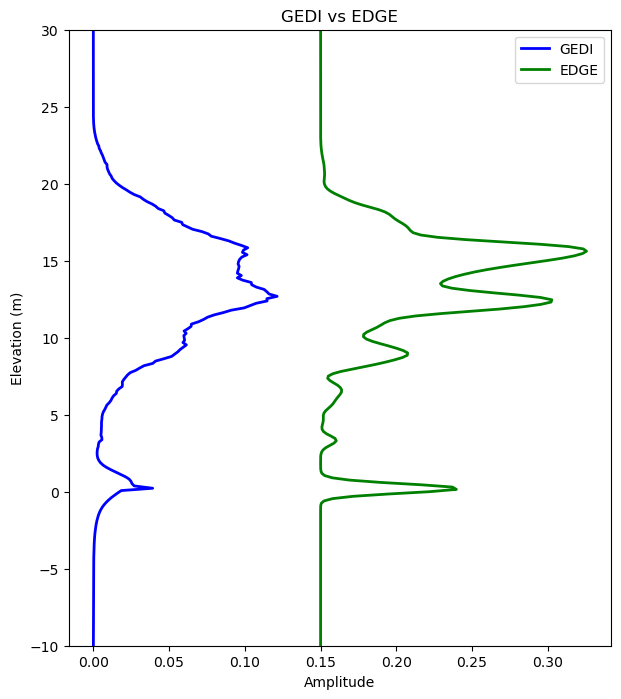

In [29]:
gedi_ind = 7
gedi_wf = gedi['RXWAVEINT'][gedi_ind]
gedi_z = np.add(gedi['ZN'][gedi_ind], np.multiply(range(1023,0,-1), ((gedi['Z0'][gedi_ind]-gedi['ZN'][gedi_ind]) / int(1023-1))))

edge_ind = 6
edge_wf = edge['RXWAVEINT'][edge_ind]
edge_z = np.add(edge['ZN'][edge_ind], np.multiply(range(1023,0,-1), ((edge['Z0'][edge_ind]-edge['ZN'][edge_ind]) / int(1023-1))))

plt.figure(figsize=(7, 8))  # Set figure size (width, height in inches)
plt.plot(gedi_wf, gedi_z, label="GEDI", color="b", linewidth=2)
plt.plot(edge_wf+0.15, edge_z, label="EDGE", color="g", linewidth=2)

plt.xlabel("Amplitude")
plt.ylabel("Elevation (m)")
plt.title("GEDI vs EDGE")
# plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.ylim(-10, 30)
plt.show()

# metrics

In [104]:
# Define column names from the provided list
column_names = [
    "wave_ID", "true_ground", "true_top", "ground_slope", "ALS_cover", "gHeight", "maxGround", "inflGround",
    "signal_top", "signal_bottom", "cover", "leading_edge_ext", "trailing_edge_extent"
] + [f"rhGauss_{i}" for i in [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]] \
  + [f"rhMax_{i}" for i in [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]] \
  + [f"rhInfl_{i}" for i in [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]] \
  + [f"rhReal_{i}" for i in [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]] \
  + ["filename", "gaussHalfCov", "maxHalfCov", "infHalfCov", "bayHalfCov", "pSigma", "fSigma", "linkM", "linkCov",
     "lon", "lat", "groundOverlap", "groundMin", "groundInfl", "waveEnergy", "blairSense", "pointDense", "beamDense",
     "zenith", "FHD", "niM2", "niM2.1", "meanNoise", "noiseStdev", "noiseThresh", "FHDhist", "FHDcan", "FHDcanHist",
     "FHDcanGauss", "FHDcanGhist", "tLAI0t10", "tLAI10t20", "tLAI20t30", "tLAI30t40", "gLAI0t10", "gLAI10t20",
     "gLAI20t30", "gLAI30t40", "hgLAI0t10", "hgLAI10t20", "hgLAI20t30", "hgLAI30t40", "hiLAI0t10", "hiLAI10t20",
     "hiLAI20t30", "hiLAI30t40", "hmLAI0t10", "hmLAI10t20", "hmLAI20t30", "hmLAI30t40", "gSlope"
]

In [120]:
# Read the file, handling missing values and formatting
fname = 'metrics/site1/EDGE/NEON_D01_BART-5x8-15m-cycle8.metric.txt'
df = pd.read_csv(fname, delim_whitespace=True, names=column_names, na_values=['?', 'inf', '-1.00'], comment='#')
df = df[['lon', 'lat', 'gHeight', 'maxGround', 'inflGround', 'signal_top', 'rhGauss_95', 'rhReal_95']]
df

,lon,lat,gHeight,maxGround,inflGround,signal_top,rhGauss_95,rhReal_95
0,315415.36,4878999.30,0.19,0.22,0.18,21.0921,18.05,NaN
1,315412.58,4879014.04,10.80,0.27,0.24,21.7418,7.79,NaN
2,315409.80,4879028.78,0.03,-0.03,0.01,24.5927,19.91,NaN
3,315407.01,4879043.52,0.13,0.12,0.10,19.9418,17.26,NaN
4,315404.23,4879058.26,0.04,-0.03,0.03,18.5914,16.75,NaN
...,...,...,...,...,...,...,...,...
550,315343.32,4879947.41,5.99,9.57,3.01,18.2739,6.28,NaN
551,315340.54,4879962.15,0.12,0.11,0.14,14.2212,12.75,NaN
552,315337.76,4879976.89,2.58,0.51,0.47,14.4714,9.94,NaN
553,315334.98,4879991.63,5.08,4.41,0.56,14.0217,6.99,NaN


In [121]:
las = laspy.read('las/NEON_D01_BART_DP1_315000_4879000_classified_point_cloud_colorized.las')
las_crs = las.header.parse_crs()
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['lon'], df['lat']), crs=las_crs)
gdf

,lon,lat,gHeight,maxGround,inflGround,signal_top,rhGauss_95,rhReal_95,geometry
0,315415.36,4878999.30,0.19,0.22,0.18,21.0921,18.05,NaN,POINT (315415.360 4878999.300)
1,315412.58,4879014.04,10.80,0.27,0.24,21.7418,7.79,NaN,POINT (315412.580 4879014.040)
2,315409.80,4879028.78,0.03,-0.03,0.01,24.5927,19.91,NaN,POINT (315409.800 4879028.780)
3,315407.01,4879043.52,0.13,0.12,0.10,19.9418,17.26,NaN,POINT (315407.010 4879043.520)
4,315404.23,4879058.26,0.04,-0.03,0.03,18.5914,16.75,NaN,POINT (315404.230 4879058.260)
...,...,...,...,...,...,...,...,...,...
550,315343.32,4879947.41,5.99,9.57,3.01,18.2739,6.28,NaN,POINT (315343.320 4879947.410)
551,315340.54,4879962.15,0.12,0.11,0.14,14.2212,12.75,NaN,POINT (315340.540 4879962.150)
552,315337.76,4879976.89,2.58,0.51,0.47,14.4714,9.94,NaN,POINT (315337.760 4879976.890)
553,315334.98,4879991.63,5.08,4.41,0.56,14.0217,6.99,NaN,POINT (315334.980 4879991.630)


In [122]:
gdf.to_file(fname.replace('.txt', '.GPKG'), driver="GPKG")

# ALS calval

In [83]:
df = pd.read_parquet('/gpfs/data1/vclgp/decontot/data/calval/calval_dataframe_20240223.parquet')

In [84]:
len(df)

9273604

In [85]:
# Identify valid crossovers (those that have realistic values)
nan = np.nan
df_valid = df.query('(`/reference/canopy_ht/canopy_ht_q100` != @nan) and \
                    (`/reference/canopy_ht/canopy_ht_q100` < 100) and \
                    (`/reference/canopy_ht/canopy_ht_q000` > -5) and \
                    (`/simulation/als_zt` != @nan) and \
                    (`/simulation/als_zg` != @nan) and \
                    (`/simulation/als_rh100` < 150) and \
                    (`/land_cover_data/urban_proportion` == 0)')

# VALID_SITES = ['neon_bart2018']
# valid = df_valid['/simulation/als_project'].isin(VALID_SITES)
# df_valid = df_valid[valid]

len(df_valid)

6752350

In [87]:
del df

In [86]:
df_valid_f = gpd.GeoDataFrame(df_valid, geometry=gpd.points_from_xy(df_valid['/geolocation/longitude'], df_valid['/geolocation/latitude']), crs="EPSG:4326")
df_valid_f = df_valid_f[df_valid_f.intersects(sites[1])].reset_index(drop=True)
df_valid_f

,/gedi/beam,/gedi/digital_elevation_model,/gedi/gedi_date,/gedi/gedi_rh_a1/botloc,/gedi/gedi_rh_a1/elev_highestreturn,/gedi/gedi_rh_a1/elev_lowestmode,/gedi/gedi_rh_a1/elev_lowestreturn,/gedi/gedi_rh_a1/gedi_rh000,/gedi/gedi_rh_a1/gedi_rh005,/gedi/gedi_rh_a1/gedi_rh010,...,rx_energy,geolocation/delta_time,geolocation/degrade,geolocation/digital_elevation_model,root_beam,root_file_l1b,nummodes,mw,date_time,geometry
0,BEAM0110,613.186890,2019-07-14,451.25,625.747742,616.232544,602.933655,NaN,NaN,-6.96,...,21167.8125,4.833029e+07,0,613.186890,BEAM0110,GEDI01_B_2019195081130_O03315_03_T05405_02_005...,3,31.0,2019-07-14 10:04:46.570983,POINT (-71.30879 44.04327)
1,BEAM0110,613.186890,2019-07-14,451.25,625.747742,616.232544,602.933655,NaN,NaN,-6.96,...,21167.8125,4.833029e+07,0,613.186890,BEAM0110,GEDI01_B_2019195081130_O03315_03_T05405_02_005...,3,31.0,2019-07-14 10:04:46.570983,POINT (-71.30876 44.04330)
2,BEAM0110,613.186890,2019-07-14,451.25,625.747742,616.232544,602.933655,NaN,NaN,-6.96,...,21167.8125,4.833029e+07,0,613.186890,BEAM0110,GEDI01_B_2019195081130_O03315_03_T05405_02_005...,3,31.0,2019-07-14 10:04:46.570983,POINT (-71.30878 44.04329)
3,BEAM0110,605.180176,2019-07-14,466.25,619.313416,610.397583,593.390015,NaN,NaN,-9.77,...,25280.0000,4.833029e+07,0,605.180176,BEAM0110,GEDI01_B_2019195081130_O03315_03_T05405_02_005...,4,31.0,2019-07-14 10:04:46.579247,POINT (-71.30815 44.04302)
4,BEAM0110,605.180176,2019-07-14,466.25,619.313416,610.397583,593.390015,NaN,NaN,-9.77,...,25280.0000,4.833029e+07,0,605.180176,BEAM0110,GEDI01_B_2019195081130_O03315_03_T05405_02_005...,5,31.0,2019-07-14 10:04:46.579247,POINT (-71.30818 44.04300)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,BEAM0101,427.611572,2022-03-05,335.25,436.750641,432.144440,430.983521,NaN,NaN,-0.71,...,2388.2500,1.316951e+08,0,427.611572,BEAM0101,GEDI01_B_2022064051852_O18274_02_T06534_02_005...,10,169.0,2022-03-05 05:57:53.626378,POINT (-71.29811 44.04669)
482,BEAM0101,427.611572,2022-03-05,335.25,436.750641,432.144440,430.983521,NaN,NaN,-0.71,...,2388.2500,1.316951e+08,0,427.611572,BEAM0101,GEDI01_B_2022064051852_O18274_02_T06534_02_005...,10,169.0,2022-03-05 05:57:53.626378,POINT (-71.29801 44.04651)
483,BEAM0101,434.250488,2022-03-05,424.50,435.912537,417.113251,415.128448,NaN,NaN,-0.86,...,2931.5000,1.316951e+08,0,434.250488,BEAM0101,GEDI01_B_2022064051852_O18274_02_T06534_02_005...,5,169.0,2022-03-05 05:57:53.634644,POINT (-71.29734 44.04699)
484,BEAM0101,434.250488,2022-03-05,424.50,435.912537,417.113251,415.128448,NaN,NaN,-0.86,...,2931.5000,1.316951e+08,0,434.250488,BEAM0101,GEDI01_B_2022064051852_O18274_02_T06534_02_005...,5,169.0,2022-03-05 05:57:53.634644,POINT (-71.29743 44.04681)


In [88]:
df_valid_f['/simulation/als_project'].unique()

<StringArray>
['neon_bart', 'neon_bart2017', 'neon_bart2016', 'neon_bart2019']
Length: 4, dtype: string

<Axes: >

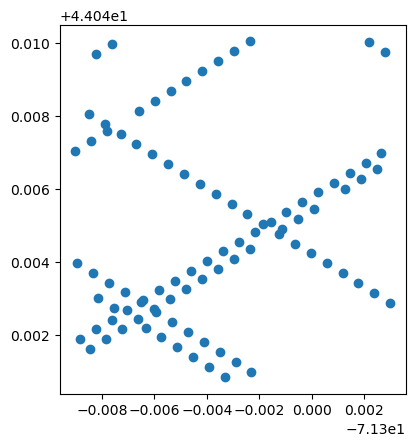

In [89]:
als_f = df_valid_f[df_valid_f['/simulation/als_project']=='neon_bart2019'].reset_index(drop=True)
als_f.plot()

In [90]:
sns = als_f['/gedi/gedi_rh_a1/shot_number'].values

orbits = sns // 10000000000000
granules = sns % 10000000000 // 100000000
aa, bb = np.unique(orbits, return_counts=True)
print(aa)
print(bb)

[ 3315  4365 13794 18274]
[30 28 12 22]


<Axes: >

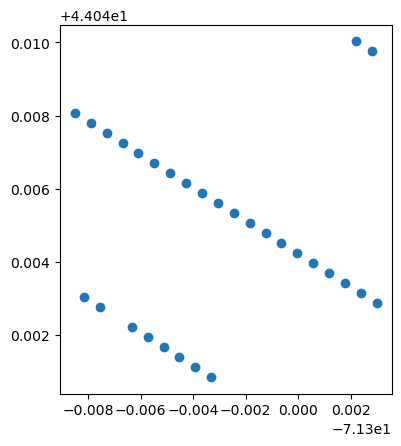

In [93]:
als_f[als_f['/gedi/orbit']==3315.].plot()

# load orbit

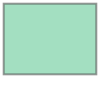

In [94]:
sites[1]
# box(-71.309040, 44.040831, -71.296917, 44.050078)

In [96]:
fname = als_f[als_f['/gedi/orbit']==3315.]['/gedi/l2a_filename'].iloc[0]
fname

'GEDI02_A_2019195081130_O03315_03_T05405_02_003_01_V002_10algs.h5'

In [183]:
# all_l2a = glob.glob('/gpfs/data1/vclgp/data/iss_gedi/soc/20*/*/GEDI02_A_*_V002_10algs.h5')
# all_l1a = glob.glob('/gpfs/data1/vclgp/data/iss_gedi/soc/20*/*/GEDI01_A_*.h5')

In [97]:
def query_GEDI_L2A(fname, gedi_L2A_fields):

    # def append_to_list(name, obj):
    #     if isinstance(obj, h5py.Dataset):
    #         gedi_L2A_fields.append(os.path.join(*name.split('/')[1:]))
    # with h5py.File(fname,'r') as f:
    #     f.visititems(append_to_list)
    # gedi_L2A_fields = list(np.unique(np.array(gedi_L2A_fields)))

    GEDI_L2A_df = []
    L2A_file = h5py.File(fname, 'r')
    beams = [x for x in L2A_file.keys() if x.startswith('BEAM')]
    for beam in beams:
        beam_df = {}
        for field in gedi_L2A_fields:
            if 'rh_' in field:
                beam_df[field] = [row for row in L2A_file[f'{beam}/{field}'][()]]
            else:
                beam_df[field] = L2A_file[f'{beam}/{field}'][()]
        beam_df = pd.DataFrame(beam_df)
        GEDI_L2A_df.append(beam_df)
    GEDI_L2A_df = pd.concat(GEDI_L2A_df, ignore_index=True)
    return GEDI_L2A_df

In [100]:
fname = '/gpfs/data1/vclgp/data/iss_gedi/soc/2019/195/GEDI02_A_2019195081130_O03315_03_T05405_02_003_01_V002_10algs.h5'

gedi_L2A_fields = [
    'shot_number',
    'geolocation/lon_lowestmode_a1',
    'geolocation/lat_lowestmode_a1',
    'selected_algorithm',
    'sensitivity',
    'beam',
    'geolocation/rh_a1',             
]

l2a_df = query_GEDI_L2A(fname, gedi_L2A_fields)

In [101]:
l2a_df = gpd.GeoDataFrame(l2a_df, geometry=gpd.points_from_xy(l2a_df['geolocation/lon_lowestmode_a1'], l2a_df['geolocation/lat_lowestmode_a1']), crs="EPSG:4326")
l2a_df_filtered = l2a_df[l2a_df.intersects(sites[1])].reset_index(drop=True)
# l2a_df_filtered = l2a_df[(l2a_df['geolocation/lon_lowestmode_a1']>-71.334689) & (l2a_df['geolocation/lon_lowestmode_a1']<-71.322567)]
l2a_df_filtered['rh95'] = np.stack(l2a_df_filtered['geolocation/rh_a1'])[:, 95]/100
l2a_df_filtered = l2a_df_filtered.drop(columns='geolocation/rh_a1')
l2a_df_filtered

,shot_number,geolocation/lon_lowestmode_a1,geolocation/lat_lowestmode_a1,selected_algorithm,sensitivity,beam,geometry,rh95
0,33150600300591757,-71.308766,44.043329,1,0.978442,6,POINT (-71.30877 44.04333),4.68
1,33150600300591758,-71.308159,44.043056,2,0.993553,6,POINT (-71.30816 44.04306),5.24
2,33150600300591759,-71.307551,44.042782,2,0.992292,6,POINT (-71.30755 44.04278),11.16
3,33150600300591760,-71.306944,44.042509,1,0.978658,6,POINT (-71.30694 44.04251),18.16
4,33150600300591761,-71.306341,44.042236,2,0.993499,6,POINT (-71.30634 44.04224),9.17
5,33150600300591762,-71.305735,44.041963,2,0.991946,6,POINT (-71.30574 44.04196),7.64
6,33150600300591763,-71.305131,44.041691,1,0.980176,6,POINT (-71.30513 44.04169),4.45
7,33150600300591764,-71.304525,44.041418,1,0.980417,6,POINT (-71.30453 44.04142),8.05
8,33150600300591765,-71.303920,44.041145,2,0.991632,6,POINT (-71.30392 44.04114),5.69
9,33150600300591766,-71.303311,44.040871,2,0.993881,6,POINT (-71.30331 44.04087),14.34


In [190]:
l2a_df_filtered.to_file('gedi_l2a.GPKG', driver="GPKG")

In [102]:
with open(f"/gpfs/data1/vclgp/aghdamim/EDGE/txts/gedi_footprint_site1.txt", "w") as file:
    for _, row in l2a_df_filtered.iterrows():
        lon, lat = row['geolocation/lon_lowestmode_a1'], row['geolocation/lat_lowestmode_a1']
        file.write(f'{lon}\t{lat}\n')

# plot waveforms

In [124]:
edge_metrics = gpd.read_file("metrics/site1/EDGE/NEON_D01_BART-5x8-15m-cycle4.metric.GPKG")
gedi_metrics = gpd.read_file("metrics/site1/GEDI_orbit/gedi_footprint_site1.metric.GPKG")

In [125]:
edge_metrics

,lon,lat,gHeight,maxGround,inflGround,signal_top,rhGauss_95,rhReal_95,geometry
0,315875.97,4879993.77,0.07,0.00,0.04,28.8320,26.06,None,POINT (315875.970 4879993.770)
1,315872.38,4879979.21,0.19,0.16,0.15,26.7331,21.44,None,POINT (315872.380 4879979.210)
2,315868.78,4879964.65,0.12,0.15,0.08,29.1317,24.96,None,POINT (315868.780 4879964.650)
3,315865.19,4879950.08,0.12,0.05,0.10,28.5820,24.41,None,POINT (315865.190 4879950.080)
4,315861.59,4879935.52,0.22,0.20,0.19,30.6821,27.16,None,POINT (315861.590 4879935.520)
...,...,...,...,...,...,...,...,...,...
555,315536.77,4879057.80,10.94,0.68,0.41,26.6530,10.75,None,POINT (315536.770 4879057.800)
556,315533.17,4879043.24,2.55,3.03,0.44,28.1014,23.45,None,POINT (315533.170 4879043.240)
557,315529.58,4879028.68,2.69,0.03,0.11,24.9539,16.86,None,POINT (315529.580 4879028.680)
558,315525.98,4879014.11,0.10,0.18,0.08,24.3514,22.00,None,POINT (315525.980 4879014.110)


In [27]:
# def h5_2_df(file):
#     keys = file.keys()
#     # df_len = len(file['BEAMDENSE'][()])
#     df = pd.DataFrame()
#     for key in keys:
#         data = file[key][()]
#         print(data.shape)
#         print(type(data))
#         if len(data)==1:
#             df[key] = data[0]
#         else:
#             df[key] = data
#     # final_gpd = pd.DataFrame(temp_df)
#     # final_gpd = gpd.GeoDataFrame(final_df, geometry=gpd.points_from_xy(final_df['longitude'], final_df['latitude']), crs="EPSG:4326")
#     return df

In [127]:
gedi_h5 = h5py.File('h5/site1/GEDI_orbit/gedi_footprint_site1.h5', 'r')
edge_h5 = h5py.File('h5/site1/EDGE/NEON_D01_BART-5x8-15m-cycle4.h5', 'r')

In [129]:
gedi_lons = gedi_h5['LON0'][()]
gedi_lats = gedi_h5['LAT0'][()]
print(np.where(np.logical_and(gedi_lons>315673, gedi_lons<315695)))
print(np.where(np.logical_and(gedi_metrics['lon']>315673, gedi_metrics['lon']<315695)))

(array([23]),)
(array([23]),)


In [130]:
edge_lons = edge_h5['LON0'][()]
edge_lats = edge_h5['LAT0'][()]
print(np.where(np.logical_and(edge_lons>315673, edge_lons<315695) * np.logical_and(edge_lats>4879384, edge_lats<4879407)))
print(np.where(np.logical_and(edge_metrics['lon']>315673, edge_metrics['lon']<315695) * np.logical_and(edge_metrics['lat']>4879384, edge_metrics['lat']<4879407)))

(array([252]),)
(array([252]),)


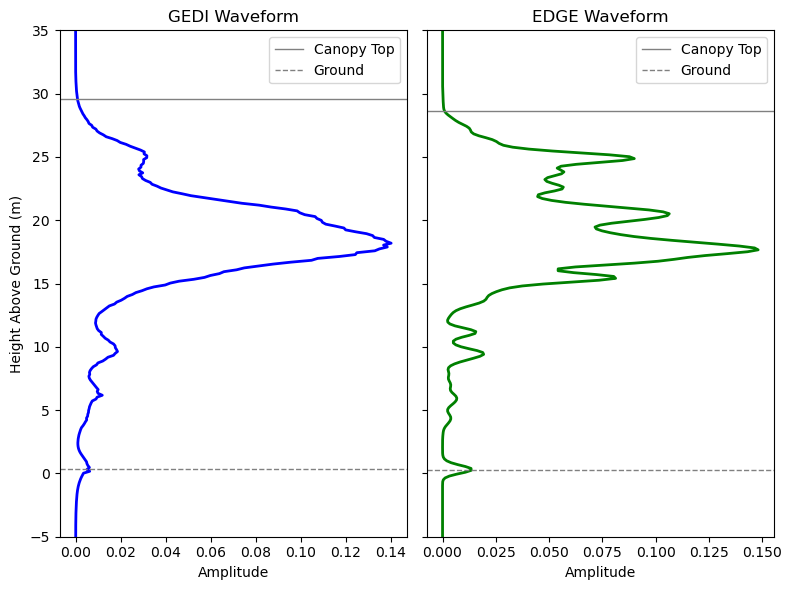

In [132]:
gedi_ind = 23
gedi_wf = gedi_h5['RXWAVEINT'][gedi_ind]
gedi_z = np.add(gedi_h5['ZN'][gedi_ind], np.multiply(range(1023,0,-1), ((gedi_h5['Z0'][gedi_ind]-gedi_h5['ZN'][gedi_ind]) / int(1023-1))))

edge_ind = 252
edge_wf = edge_h5['RXWAVEINT'][edge_ind]
edge_z = np.add(edge_h5['ZN'][edge_ind], np.multiply(range(1023,0,-1), ((edge_h5['Z0'][edge_ind]-edge_h5['ZN'][edge_ind]) / int(1023-1))))


fig, axs = plt.subplots(1, 2, figsize=(8, 6), sharey=True)  # Share y-axis

# Plot GEDI waveform
axs[0].plot(gedi_wf, gedi_z, color="b", linewidth=2)
axs[0].axhline(y=gedi_metrics['signal_top'].iloc[gedi_ind], color='grey', linestyle='-', linewidth=1, label="Canopy Top")
axs[0].axhline(y=gedi_metrics['maxGround'].iloc[gedi_ind], color='grey', linestyle='--', linewidth=1, label="Ground")
axs[0].set_xlabel("Amplitude")
axs[0].set_ylabel("Height Above Ground (m)")
axs[0].set_title("GEDI Waveform")
axs[0].legend()
axs[0].set_ylim(-5, 35)

# Plot EDGE waveform
axs[1].plot(edge_wf, edge_z, color="g", linewidth=2)
axs[1].axhline(y=edge_metrics['signal_top'].iloc[edge_ind], color='grey', linestyle='-', linewidth=1, label="Canopy Top")
axs[1].axhline(y=edge_metrics['maxGround'].iloc[edge_ind], color='grey', linestyle='--', linewidth=1, label="Ground")
axs[1].set_xlabel("Amplitude")
axs[1].set_title("EDGE Waveform")
axs[1].legend()

plt.tight_layout()
plt.savefig("figure2.png", dpi=300)
plt.show()

In [44]:
pwd

'/gpfs/data1/vclgp/aghdamim/EDGE'

In [ ]:
EDGE/h5/site0/GEDI_orbit/gedi_footprint.h5

In [ ]:
/gpfs/data1/vclgp/aghdamim/EDGE/h5/site0/EDGE/NEON_D01_BART-5x8-15m-cycle8.h5

In [ ]:
'ancillary/l2a_alg_count',
 'beam',
 'channel',
 'degrade_flag',
 'delta_time',
 'digital_elevation_model',
 'digital_elevation_model_srtm',
 'elev_highestreturn',
 'elev_lowestmode',
 'elevation_bias_flag',
 'elevation_bin0_error',
 'energy_total',
 'geolocation/elev_highestreturn_a1',
 'geolocation/elev_highestreturn_a10',
 'geolocation/elev_highestreturn_a2',
 'geolocation/elev_highestreturn_a3',
 'geolocation/elev_highestreturn_a4',
 'geolocation/elev_highestreturn_a5',
 'geolocation/elev_highestreturn_a6',
 'geolocation/elev_highestreturn_a7',
 'geolocation/elev_highestreturn_a8',
 'geolocation/elev_highestreturn_a9',
 'geolocation/elev_lowestmode_a1',
 'geolocation/elev_lowestmode_a10',
 'geolocation/elev_lowestmode_a2',
 'geolocation/elev_lowestmode_a3',
 'geolocation/elev_lowestmode_a4',
 'geolocation/elev_lowestmode_a5',
 'geolocation/elev_lowestmode_a6',
 'geolocation/elev_lowestmode_a7',
 'geolocation/elev_lowestmode_a8',
 'geolocation/elev_lowestmode_a9',
 'geolocation/elev_lowestreturn_a1',
 'geolocation/elev_lowestreturn_a10',
 'geolocation/elev_lowestreturn_a2',
 'geolocation/elev_lowestreturn_a3',
 'geolocation/elev_lowestreturn_a4',
 'geolocation/elev_lowestreturn_a5',
 'geolocation/elev_lowestreturn_a6',
 'geolocation/elev_lowestreturn_a7',
 'geolocation/elev_lowestreturn_a8',
 'geolocation/elev_lowestreturn_a9',
 'geolocation/elevation_1gfit',
 'geolocation/elevs_allmodes_a1',
 'geolocation/elevs_allmodes_a10',
 'geolocation/elevs_allmodes_a2',
 'geolocation/elevs_allmodes_a3',
 'geolocation/elevs_allmodes_a4',
 'geolocation/elevs_allmodes_a5',
 'geolocation/elevs_allmodes_a6',
 'geolocation/elevs_allmodes_a7',
 'geolocation/elevs_allmodes_a8',
 'geolocation/elevs_allmodes_a9',
 'geolocation/energy_lowestmode_a1',
 'geolocation/energy_lowestmode_a10',
 'geolocation/energy_lowestmode_a2',
 'geolocation/energy_lowestmode_a3',
 'geolocation/energy_lowestmode_a4',
 'geolocation/energy_lowestmode_a5',
 'geolocation/energy_lowestmode_a6',
 'geolocation/energy_lowestmode_a7',
 'geolocation/energy_lowestmode_a8',
 'geolocation/energy_lowestmode_a9',
 'geolocation/lat_highestreturn_a1',
 'geolocation/lat_highestreturn_a10',
 'geolocation/lat_highestreturn_a2',
 'geolocation/lat_highestreturn_a3',
 'geolocation/lat_highestreturn_a4',
 'geolocation/lat_highestreturn_a5',
 'geolocation/lat_highestreturn_a6',
 'geolocation/lat_highestreturn_a7',
 'geolocation/lat_highestreturn_a8',
 'geolocation/lat_highestreturn_a9',
 'geolocation/lat_lowestmode_a1',
 'geolocation/lat_lowestmode_a10',
 'geolocation/lat_lowestmode_a2',
 'geolocation/lat_lowestmode_a3',
 'geolocation/lat_lowestmode_a4',
 'geolocation/lat_lowestmode_a5',
 'geolocation/lat_lowestmode_a6',
 'geolocation/lat_lowestmode_a7',
 'geolocation/lat_lowestmode_a8',
 'geolocation/lat_lowestmode_a9',
 'geolocation/lat_lowestreturn_a1',
 'geolocation/lat_lowestreturn_a10',
 'geolocation/lat_lowestreturn_a2',
 'geolocation/lat_lowestreturn_a3',
 'geolocation/lat_lowestreturn_a4',
 'geolocation/lat_lowestreturn_a5',
 'geolocation/lat_lowestreturn_a6',
 'geolocation/lat_lowestreturn_a7',
 'geolocation/lat_lowestreturn_a8',
 'geolocation/lat_lowestreturn_a9',
 'geolocation/latitude_1gfit',
 'geolocation/lats_allmodes_a1',
 'geolocation/lats_allmodes_a10',
 'geolocation/lats_allmodes_a2',
 'geolocation/lats_allmodes_a3',
 'geolocation/lats_allmodes_a4',
 'geolocation/lats_allmodes_a5',
 'geolocation/lats_allmodes_a6',
 'geolocation/lats_allmodes_a7',
 'geolocation/lats_allmodes_a8',
 'geolocation/lats_allmodes_a9',
 'geolocation/lon_highestreturn_a1',
 'geolocation/lon_highestreturn_a10',
 'geolocation/lon_highestreturn_a2',
 'geolocation/lon_highestreturn_a3',
 'geolocation/lon_highestreturn_a4',
 'geolocation/lon_highestreturn_a5',
 'geolocation/lon_highestreturn_a6',
 'geolocation/lon_highestreturn_a7',
 'geolocation/lon_highestreturn_a8',
 'geolocation/lon_highestreturn_a9',
 'geolocation/lon_lowestmode_a1',
 'geolocation/lon_lowestmode_a10',
 'geolocation/lon_lowestmode_a2',
 'geolocation/lon_lowestmode_a3',
 'geolocation/lon_lowestmode_a4',
 'geolocation/lon_lowestmode_a5',
 'geolocation/lon_lowestmode_a6',
 'geolocation/lon_lowestmode_a7',
 'geolocation/lon_lowestmode_a8',
 'geolocation/lon_lowestmode_a9',
 'geolocation/lon_lowestreturn_a1',
 'geolocation/lon_lowestreturn_a10',
 'geolocation/lon_lowestreturn_a2',
 'geolocation/lon_lowestreturn_a3',
 'geolocation/lon_lowestreturn_a4',
 'geolocation/lon_lowestreturn_a5',
 'geolocation/lon_lowestreturn_a6',
 'geolocation/lon_lowestreturn_a7',
 'geolocation/lon_lowestreturn_a8',
 'geolocation/lon_lowestreturn_a9',
 'geolocation/longitude_1gfit',
 'geolocation/lons_allmodes_a1',
 'geolocation/lons_allmodes_a10',
 'geolocation/lons_allmodes_a2',
 'geolocation/lons_allmodes_a3',
 'geolocation/lons_allmodes_a4',
 'geolocation/lons_allmodes_a5',
 'geolocation/lons_allmodes_a6',
 'geolocation/lons_allmodes_a7',
 'geolocation/lons_allmodes_a8',
 'geolocation/lons_allmodes_a9',
 'geolocation/num_detectedmodes_a1',
 'geolocation/num_detectedmodes_a10',
 'geolocation/num_detectedmodes_a2',
 'geolocation/num_detectedmodes_a3',
 'geolocation/num_detectedmodes_a4',
 'geolocation/num_detectedmodes_a5',
 'geolocation/num_detectedmodes_a6',
 'geolocation/num_detectedmodes_a7',
 'geolocation/num_detectedmodes_a8',
 'geolocation/num_detectedmodes_a9',
 'geolocation/quality_flag_a1',
 'geolocation/quality_flag_a10',
 'geolocation/quality_flag_a2',
 'geolocation/quality_flag_a3',
 'geolocation/quality_flag_a4',
 'geolocation/quality_flag_a5',
 'geolocation/quality_flag_a6',
 'geolocation/quality_flag_a7',
 'geolocation/quality_flag_a8',
 'geolocation/quality_flag_a9',
 'geolocation/rh_a1',
 'geolocation/rh_a10',
 'geolocation/rh_a2',
 'geolocation/rh_a3',
 'geolocation/rh_a4',
 'geolocation/rh_a5',
 'geolocation/rh_a6',
 'geolocation/rh_a7',
 'geolocation/rh_a8',
 'geolocation/rh_a9',
 'geolocation/sensitivity_a1',
 'geolocation/sensitivity_a10',
 'geolocation/sensitivity_a2',
 'geolocation/sensitivity_a3',
 'geolocation/sensitivity_a4',
 'geolocation/sensitivity_a5',
 'geolocation/sensitivity_a6',
 'geolocation/sensitivity_a7',
 'geolocation/sensitivity_a8',
 'geolocation/sensitivity_a9',
 'geolocation/stale_return_flag',
 'land_cover_data/landsat_treecover',
 'land_cover_data/landsat_water_persistence',
 'land_cover_data/leaf_off_doy',
 'land_cover_data/leaf_off_flag',
 'land_cover_data/leaf_on_cycle',
 'land_cover_data/leaf_on_doy',
 'land_cover_data/modis_nonvegetated',
 'land_cover_data/modis_nonvegetated_sd',
 'land_cover_data/modis_treecover',
 'land_cover_data/modis_treecover_sd',
 'land_cover_data/pft_class',
 'land_cover_data/region_class',
 'land_cover_data/urban_focal_window_size',
 'land_cover_data/urban_proportion',
 'lat_highestreturn',
 'lat_lowestmode',
 'latitude_bin0_error',
 'lon_highestreturn',
 'lon_lowestmode',
 'longitude_bin0_error',
 'master_frac',
 'master_int',
 'mean_sea_surface',
 'num_detectedmodes',
 'quality_flag',
 'rh',
 'rx_1gaussfit/ancillary/mpfit_max_func_evals',
 'rx_1gaussfit/ancillary/mpfit_maxiters',
 'rx_1gaussfit/ancillary/mpfit_tolerance',
 'rx_1gaussfit/ancillary/rx_constraint_gamplitude_lower',
 'rx_1gaussfit/ancillary/rx_constraint_gamplitude_upper',
 'rx_1gaussfit/ancillary/rx_constraint_gloc_lower',
 'rx_1gaussfit/ancillary/rx_constraint_gloc_upper',
 'rx_1gaussfit/ancillary/rx_constraint_gwidth_lower',
 'rx_1gaussfit/ancillary/rx_constraint_gwidth_upper',
 'rx_1gaussfit/ancillary/rx_estimate_bias',
 'rx_1gaussfit/ancillary/rx_mean_noise_level',
 'rx_1gaussfit/ancillary/rx_smoothwidth',
 'rx_1gaussfit/rx_gamplitude',
 'rx_1gaussfit/rx_gamplitude_error',
 'rx_1gaussfit/rx_gbias',
 'rx_1gaussfit/rx_gbias_error',
 'rx_1gaussfit/rx_gchisq',
 'rx_1gaussfit/rx_gflag',
 'rx_1gaussfit/rx_giters',
 'rx_1gaussfit/rx_gloc',
 'rx_1gaussfit/rx_gloc_error',
 'rx_1gaussfit/rx_gwidth',
 'rx_1gaussfit/rx_gwidth_error',
 'rx_assess/ancillary/rx_ampbounds_ll',
 'rx_assess/ancillary/rx_ampbounds_ul',
 'rx_assess/ancillary/rx_clipamp',
 'rx_assess/ancillary/rx_pulsethresh',
 'rx_assess/ancillary/rx_ringthresh',
 'rx_assess/ancillary/smoothing_width_locs',
 'rx_assess/mean',
 'rx_assess/mean_64kadjusted',
 'rx_assess/ocean_calibration_shot_flag',
 'rx_assess/quality_flag',
 'rx_assess/rx_assess_flag',
 'rx_assess/rx_clipbin0',
 'rx_assess/rx_clipbin_count',
 'rx_assess/rx_energy',
 'rx_assess/rx_maxamp',
 'rx_assess/rx_maxpeakloc',
 'rx_assess/sd_corrected',
 'rx_processing_a1/ancillary/amp_thresh',
 'rx_processing_a1/ancillary/ampval_limit2',
 'rx_processing_a1/ancillary/ampval_limit3',
 'rx_processing_a1/ancillary/botlocdist_limit1',
 'rx_processing_a1/ancillary/botlocdist_limit2',
 'rx_processing_a1/ancillary/botlocdist_limit3',
 'rx_processing_a1/ancillary/cumulative_energy_minimum',
 'rx_processing_a1/ancillary/cumulative_energy_thresh',
 'rx_processing_a1/ancillary/enable_select_mode',
 'rx_processing_a1/ancillary/energy_thresh',
 'rx_processing_a1/ancillary/preprocessor_threshold',
 'rx_processing_a1/ancillary/pulse_sep_thresh',
 'rx_processing_a1/ancillary/rx_back_threshold',
 'rx_processing_a1/ancillary/rx_front_threshold',
 'rx_processing_a1/ancillary/rx_max_mode_count',
 'rx_processing_a1/ancillary/rx_searchsize',
 'rx_processing_a1/ancillary/rx_sentinel_location',
 'rx_processing_a1/ancillary/rx_smoothing_width_locs',
 'rx_processing_a1/ancillary/rx_smoothing_width_zcross',
 'rx_processing_a1/ancillary/rx_subbin_resolution',
 'rx_processing_a1/ancillary/rx_use_fixed_thresholds',
 'rx_processing_a1/back_threshold',
 'rx_processing_a1/botloc',
 'rx_processing_a1/botloc_amp',
 'rx_processing_a1/energy_sm',
 'rx_processing_a1/front_threshold',
 'rx_processing_a1/lastmodeenergy',
 'rx_processing_a1/mean',
 'rx_processing_a1/mean_sm',
 'rx_processing_a1/min_detection_energy',
 'rx_processing_a1/min_detection_threshold',
 'rx_processing_a1/peak',
 'rx_processing_a1/pk_sm',
 'rx_processing_a1/rx_algrunflag',
 'rx_processing_a1/rx_cumulative',
 'rx_processing_a1/rx_iwaveamps',
 'rx_processing_a1/rx_modeamps',
 'rx_processing_a1/rx_modeenergytobotloc',
 'rx_processing_a1/rx_modelocalenergy',
 'rx_processing_a1/rx_modelocalenergyabovemean',
 'rx_processing_a1/rx_modelocalslope',
 'rx_processing_a1/rx_modelocs',
 'rx_processing_a1/rx_modewidths',
 'rx_processing_a1/rx_nummodes',
 'rx_processing_a1/sd_sm',
 'rx_processing_a1/search_end',
 'rx_processing_a1/search_start',
 'rx_processing_a1/selected_mode',
 'rx_processing_a1/selected_mode_flag',
 'rx_processing_a1/smoothwidth',
 'rx_processing_a1/smoothwidth_zcross',
 'rx_processing_a1/stddev',
 'rx_processing_a1/toploc',
 'rx_processing_a1/toploc_miss',
 'rx_processing_a1/zcross',
 'rx_processing_a1/zcross0',
 'rx_processing_a1/zcross_amp',
 'rx_processing_a1/zcross_localenergy',
 'rx_processing_a10/ancillary/amp_thresh',
 'rx_processing_a10/ancillary/ampval_limit2',
 'rx_processing_a10/ancillary/ampval_limit3',
 'rx_processing_a10/ancillary/botlocdist_limit1',
 'rx_processing_a10/ancillary/botlocdist_limit2',
 'rx_processing_a10/ancillary/botlocdist_limit3',
 'rx_processing_a10/ancillary/cumulative_energy_minimum',
 'rx_processing_a10/ancillary/cumulative_energy_thresh',
 'rx_processing_a10/ancillary/enable_select_mode',
 'rx_processing_a10/ancillary/energy_thresh',
 'rx_processing_a10/ancillary/preprocessor_threshold',
 'rx_processing_a10/ancillary/pulse_sep_thresh',
 'rx_processing_a10/ancillary/rx_back_threshold',
 'rx_processing_a10/ancillary/rx_front_threshold',
 'rx_processing_a10/ancillary/rx_max_mode_count',
 'rx_processing_a10/ancillary/rx_searchsize',
 'rx_processing_a10/ancillary/rx_sentinel_location',
 'rx_processing_a10/ancillary/rx_smoothing_width_locs',
 'rx_processing_a10/ancillary/rx_smoothing_width_zcross',
 'rx_processing_a10/ancillary/rx_subbin_resolution',
 'rx_processing_a10/ancillary/rx_use_fixed_thresholds',
 'rx_processing_a10/back_threshold',
 'rx_processing_a10/botloc',
 'rx_processing_a10/botloc_amp',
 'rx_processing_a10/energy_sm',
 'rx_processing_a10/front_threshold',
 'rx_processing_a10/lastmodeenergy',
 'rx_processing_a10/mean',
 'rx_processing_a10/mean_sm',
 'rx_processing_a10/min_detection_energy',
 'rx_processing_a10/min_detection_threshold',
 'rx_processing_a10/peak',
 'rx_processing_a10/pk_sm',
 'rx_processing_a10/rx_algrunflag',
 'rx_processing_a10/rx_cumulative',
 'rx_processing_a10/rx_iwaveamps',
 'rx_processing_a10/rx_modeamps',
 'rx_processing_a10/rx_modeenergytobotloc',
 'rx_processing_a10/rx_modelocalenergy',
 'rx_processing_a10/rx_modelocalenergyabovemean',
 'rx_processing_a10/rx_modelocalslope',
 'rx_processing_a10/rx_modelocs',
 'rx_processing_a10/rx_modewidths',
 'rx_processing_a10/rx_nummodes',
 'rx_processing_a10/sd_sm',
 'rx_processing_a10/search_end',
 'rx_processing_a10/search_start',
 'rx_processing_a10/selected_mode',
 'rx_processing_a10/selected_mode_flag',
 'rx_processing_a10/smoothwidth',
 'rx_processing_a10/smoothwidth_zcross',
 'rx_processing_a10/stddev',
 'rx_processing_a10/toploc',
 'rx_processing_a10/toploc_miss',
 'rx_processing_a10/zcross',
 'rx_processing_a10/zcross0',
 'rx_processing_a10/zcross_amp',
 'rx_processing_a10/zcross_localenergy',
 'rx_processing_a2/ancillary/amp_thresh',
 'rx_processing_a2/ancillary/ampval_limit2',
 'rx_processing_a2/ancillary/ampval_limit3',
 'rx_processing_a2/ancillary/botlocdist_limit1',
 'rx_processing_a2/ancillary/botlocdist_limit2',
 'rx_processing_a2/ancillary/botlocdist_limit3',
 'rx_processing_a2/ancillary/cumulative_energy_minimum',
 'rx_processing_a2/ancillary/cumulative_energy_thresh',
 'rx_processing_a2/ancillary/enable_select_mode',
 'rx_processing_a2/ancillary/energy_thresh',
 'rx_processing_a2/ancillary/preprocessor_threshold',
 'rx_processing_a2/ancillary/pulse_sep_thresh',
 'rx_processing_a2/ancillary/rx_back_threshold',
 'rx_processing_a2/ancillary/rx_front_threshold',
 'rx_processing_a2/ancillary/rx_max_mode_count',
 'rx_processing_a2/ancillary/rx_searchsize',
 'rx_processing_a2/ancillary/rx_sentinel_location',
 'rx_processing_a2/ancillary/rx_smoothing_width_locs',
 'rx_processing_a2/ancillary/rx_smoothing_width_zcross',
 'rx_processing_a2/ancillary/rx_subbin_resolution',
 'rx_processing_a2/ancillary/rx_use_fixed_thresholds',
 'rx_processing_a2/back_threshold',
 'rx_processing_a2/botloc',
 'rx_processing_a2/botloc_amp',
 'rx_processing_a2/energy_sm',
 'rx_processing_a2/front_threshold',
 'rx_processing_a2/lastmodeenergy',
 'rx_processing_a2/mean',
 'rx_processing_a2/mean_sm',
 'rx_processing_a2/min_detection_energy',
 'rx_processing_a2/min_detection_threshold',
 'rx_processing_a2/peak',
 'rx_processing_a2/pk_sm',
 'rx_processing_a2/rx_algrunflag',
 'rx_processing_a2/rx_cumulative',
 'rx_processing_a2/rx_iwaveamps',
 'rx_processing_a2/rx_modeamps',
 'rx_processing_a2/rx_modeenergytobotloc',
 'rx_processing_a2/rx_modelocalenergy',
 'rx_processing_a2/rx_modelocalenergyabovemean',
 'rx_processing_a2/rx_modelocalslope',
 'rx_processing_a2/rx_modelocs',
 'rx_processing_a2/rx_modewidths',
 'rx_processing_a2/rx_nummodes',
 'rx_processing_a2/sd_sm',
 'rx_processing_a2/search_end',
 'rx_processing_a2/search_start',
 'rx_processing_a2/selected_mode',
 'rx_processing_a2/selected_mode_flag',
 'rx_processing_a2/smoothwidth',
 'rx_processing_a2/smoothwidth_zcross',
 'rx_processing_a2/stddev',
 'rx_processing_a2/toploc',
 'rx_processing_a2/toploc_miss',
 'rx_processing_a2/zcross',
 'rx_processing_a2/zcross0',
 'rx_processing_a2/zcross_amp',
 'rx_processing_a2/zcross_localenergy',
 'rx_processing_a3/ancillary/amp_thresh',
 'rx_processing_a3/ancillary/ampval_limit2',
 'rx_processing_a3/ancillary/ampval_limit3',
 'rx_processing_a3/ancillary/botlocdist_limit1',
 'rx_processing_a3/ancillary/botlocdist_limit2',
 'rx_processing_a3/ancillary/botlocdist_limit3',
 'rx_processing_a3/ancillary/cumulative_energy_minimum',
 'rx_processing_a3/ancillary/cumulative_energy_thresh',
 'rx_processing_a3/ancillary/enable_select_mode',
 'rx_processing_a3/ancillary/energy_thresh',
 'rx_processing_a3/ancillary/preprocessor_threshold',
 'rx_processing_a3/ancillary/pulse_sep_thresh',
 'rx_processing_a3/ancillary/rx_back_threshold',
 'rx_processing_a3/ancillary/rx_front_threshold',
 'rx_processing_a3/ancillary/rx_max_mode_count',
 'rx_processing_a3/ancillary/rx_searchsize',
 'rx_processing_a3/ancillary/rx_sentinel_location',
 'rx_processing_a3/ancillary/rx_smoothing_width_locs',
 'rx_processing_a3/ancillary/rx_smoothing_width_zcross',
 'rx_processing_a3/ancillary/rx_subbin_resolution',
 'rx_processing_a3/ancillary/rx_use_fixed_thresholds',
 'rx_processing_a3/back_threshold',
 'rx_processing_a3/botloc',
 'rx_processing_a3/botloc_amp',
 'rx_processing_a3/energy_sm',
 'rx_processing_a3/front_threshold',
 'rx_processing_a3/lastmodeenergy',
 'rx_processing_a3/mean',
 'rx_processing_a3/mean_sm',
 'rx_processing_a3/min_detection_energy',
 'rx_processing_a3/min_detection_threshold',
 'rx_processing_a3/peak',
 'rx_processing_a3/pk_sm',
 'rx_processing_a3/rx_algrunflag',
 'rx_processing_a3/rx_cumulative',
 'rx_processing_a3/rx_iwaveamps',
 'rx_processing_a3/rx_modeamps',
 'rx_processing_a3/rx_modeenergytobotloc',
 'rx_processing_a3/rx_modelocalenergy',
 'rx_processing_a3/rx_modelocalenergyabovemean',
 'rx_processing_a3/rx_modelocalslope',
 'rx_processing_a3/rx_modelocs',
 'rx_processing_a3/rx_modewidths',
 'rx_processing_a3/rx_nummodes',
 'rx_processing_a3/sd_sm',
 'rx_processing_a3/search_end',
 'rx_processing_a3/search_start',
 'rx_processing_a3/selected_mode',
 'rx_processing_a3/selected_mode_flag',
 'rx_processing_a3/smoothwidth',
 'rx_processing_a3/smoothwidth_zcross',
 'rx_processing_a3/stddev',
 'rx_processing_a3/toploc',
 'rx_processing_a3/toploc_miss',
 'rx_processing_a3/zcross',
 'rx_processing_a3/zcross0',
 'rx_processing_a3/zcross_amp',
 'rx_processing_a3/zcross_localenergy',
 'rx_processing_a4/ancillary/amp_thresh',
 'rx_processing_a4/ancillary/ampval_limit2',
 'rx_processing_a4/ancillary/ampval_limit3',
 'rx_processing_a4/ancillary/botlocdist_limit1',
 'rx_processing_a4/ancillary/botlocdist_limit2',
 'rx_processing_a4/ancillary/botlocdist_limit3',
 'rx_processing_a4/ancillary/cumulative_energy_minimum',
 'rx_processing_a4/ancillary/cumulative_energy_thresh',
 'rx_processing_a4/ancillary/enable_select_mode',
 'rx_processing_a4/ancillary/energy_thresh',
 'rx_processing_a4/ancillary/preprocessor_threshold',
 'rx_processing_a4/ancillary/pulse_sep_thresh',
 'rx_processing_a4/ancillary/rx_back_threshold',
 'rx_processing_a4/ancillary/rx_front_threshold',
 'rx_processing_a4/ancillary/rx_max_mode_count',
 'rx_processing_a4/ancillary/rx_searchsize',
 'rx_processing_a4/ancillary/rx_sentinel_location',
 'rx_processing_a4/ancillary/rx_smoothing_width_locs',
 'rx_processing_a4/ancillary/rx_smoothing_width_zcross',
 'rx_processing_a4/ancillary/rx_subbin_resolution',
 'rx_processing_a4/ancillary/rx_use_fixed_thresholds',
 'rx_processing_a4/back_threshold',
 'rx_processing_a4/botloc',
 'rx_processing_a4/botloc_amp',
 'rx_processing_a4/energy_sm',
 'rx_processing_a4/front_threshold',
 'rx_processing_a4/lastmodeenergy',
 'rx_processing_a4/mean',
 'rx_processing_a4/mean_sm',
 'rx_processing_a4/min_detection_energy',
 'rx_processing_a4/min_detection_threshold',
 'rx_processing_a4/peak',
 'rx_processing_a4/pk_sm',
 'rx_processing_a4/rx_algrunflag',
 'rx_processing_a4/rx_cumulative',
 'rx_processing_a4/rx_iwaveamps',
 'rx_processing_a4/rx_modeamps',
 'rx_processing_a4/rx_modeenergytobotloc',
 'rx_processing_a4/rx_modelocalenergy',
 'rx_processing_a4/rx_modelocalenergyabovemean',
 'rx_processing_a4/rx_modelocalslope',
 'rx_processing_a4/rx_modelocs',
 'rx_processing_a4/rx_modewidths',
 'rx_processing_a4/rx_nummodes',
 'rx_processing_a4/sd_sm',
 'rx_processing_a4/search_end',
 'rx_processing_a4/search_start',
 'rx_processing_a4/selected_mode',
 'rx_processing_a4/selected_mode_flag',
 'rx_processing_a4/smoothwidth',
 'rx_processing_a4/smoothwidth_zcross',
 'rx_processing_a4/stddev',
 'rx_processing_a4/toploc',
 'rx_processing_a4/toploc_miss',
 'rx_processing_a4/zcross',
 'rx_processing_a4/zcross0',
 'rx_processing_a4/zcross_amp',
 'rx_processing_a4/zcross_localenergy',
 'rx_processing_a5/ancillary/amp_thresh',
 'rx_processing_a5/ancillary/ampval_limit2',
 'rx_processing_a5/ancillary/ampval_limit3',
 'rx_processing_a5/ancillary/botlocdist_limit1',
 'rx_processing_a5/ancillary/botlocdist_limit2',
 'rx_processing_a5/ancillary/botlocdist_limit3',
 'rx_processing_a5/ancillary/cumulative_energy_minimum',
 'rx_processing_a5/ancillary/cumulative_energy_thresh',
 'rx_processing_a5/ancillary/enable_select_mode',
 'rx_processing_a5/ancillary/energy_thresh',
 'rx_processing_a5/ancillary/preprocessor_threshold',
 'rx_processing_a5/ancillary/pulse_sep_thresh',
 'rx_processing_a5/ancillary/rx_back_threshold',
 'rx_processing_a5/ancillary/rx_front_threshold',
 'rx_processing_a5/ancillary/rx_max_mode_count',
 'rx_processing_a5/ancillary/rx_searchsize',
 'rx_processing_a5/ancillary/rx_sentinel_location',
 'rx_processing_a5/ancillary/rx_smoothing_width_locs',
 'rx_processing_a5/ancillary/rx_smoothing_width_zcross',
 'rx_processing_a5/ancillary/rx_subbin_resolution',
 'rx_processing_a5/ancillary/rx_use_fixed_thresholds',
 'rx_processing_a5/back_threshold',
 'rx_processing_a5/botloc',
 'rx_processing_a5/botloc_amp',
 'rx_processing_a5/energy_sm',
 'rx_processing_a5/front_threshold',
 'rx_processing_a5/lastmodeenergy',
 'rx_processing_a5/mean',
 'rx_processing_a5/mean_sm',
 'rx_processing_a5/min_detection_energy',
 'rx_processing_a5/min_detection_threshold',
 'rx_processing_a5/peak',
 'rx_processing_a5/pk_sm',
 'rx_processing_a5/rx_algrunflag',
 'rx_processing_a5/rx_cumulative',
 'rx_processing_a5/rx_iwaveamps',
 'rx_processing_a5/rx_modeamps',
 'rx_processing_a5/rx_modeenergytobotloc',
 'rx_processing_a5/rx_modelocalenergy',
 'rx_processing_a5/rx_modelocalenergyabovemean',
 'rx_processing_a5/rx_modelocalslope',
 'rx_processing_a5/rx_modelocs',
 'rx_processing_a5/rx_modewidths',
 'rx_processing_a5/rx_nummodes',
 'rx_processing_a5/sd_sm',
 'rx_processing_a5/search_end',
 'rx_processing_a5/search_start',
 'rx_processing_a5/selected_mode',
 'rx_processing_a5/selected_mode_flag',
 'rx_processing_a5/smoothwidth',
 'rx_processing_a5/smoothwidth_zcross',
 'rx_processing_a5/stddev',
 'rx_processing_a5/toploc',
 'rx_processing_a5/toploc_miss',
 'rx_processing_a5/zcross',
 'rx_processing_a5/zcross0',
 'rx_processing_a5/zcross_amp',
 'rx_processing_a5/zcross_localenergy',
 'rx_processing_a6/ancillary/amp_thresh',
 'rx_processing_a6/ancillary/ampval_limit2',
 'rx_processing_a6/ancillary/ampval_limit3',
 'rx_processing_a6/ancillary/botlocdist_limit1',
 'rx_processing_a6/ancillary/botlocdist_limit2',
 'rx_processing_a6/ancillary/botlocdist_limit3',
 'rx_processing_a6/ancillary/cumulative_energy_minimum',
 'rx_processing_a6/ancillary/cumulative_energy_thresh',
 'rx_processing_a6/ancillary/enable_select_mode',
 'rx_processing_a6/ancillary/energy_thresh',
 'rx_processing_a6/ancillary/preprocessor_threshold',
 'rx_processing_a6/ancillary/pulse_sep_thresh',
 'rx_processing_a6/ancillary/rx_back_threshold',
 'rx_processing_a6/ancillary/rx_front_threshold',
 'rx_processing_a6/ancillary/rx_max_mode_count',
 'rx_processing_a6/ancillary/rx_searchsize',
 'rx_processing_a6/ancillary/rx_sentinel_location',
 'rx_processing_a6/ancillary/rx_smoothing_width_locs',
 'rx_processing_a6/ancillary/rx_smoothing_width_zcross',
 'rx_processing_a6/ancillary/rx_subbin_resolution',
 'rx_processing_a6/ancillary/rx_use_fixed_thresholds',
 'rx_processing_a6/back_threshold',
 'rx_processing_a6/botloc',
 'rx_processing_a6/botloc_amp',
 'rx_processing_a6/energy_sm',
 'rx_processing_a6/front_threshold',
 'rx_processing_a6/lastmodeenergy',
 'rx_processing_a6/mean',
 'rx_processing_a6/mean_sm',
 'rx_processing_a6/min_detection_energy',
 'rx_processing_a6/min_detection_threshold',
 'rx_processing_a6/peak',
 'rx_processing_a6/pk_sm',
 'rx_processing_a6/rx_algrunflag',
 'rx_processing_a6/rx_cumulative',
 'rx_processing_a6/rx_iwaveamps',
 'rx_processing_a6/rx_modeamps',
 'rx_processing_a6/rx_modeenergytobotloc',
 'rx_processing_a6/rx_modelocalenergy',
 'rx_processing_a6/rx_modelocalenergyabovemean',
 'rx_processing_a6/rx_modelocalslope',
 'rx_processing_a6/rx_modelocs',
 'rx_processing_a6/rx_modewidths',
 'rx_processing_a6/rx_nummodes',
 'rx_processing_a6/sd_sm',
 'rx_processing_a6/search_end',
 'rx_processing_a6/search_start',
 'rx_processing_a6/selected_mode',
 'rx_processing_a6/selected_mode_flag',
 'rx_processing_a6/smoothwidth',
 'rx_processing_a6/smoothwidth_zcross',
 'rx_processing_a6/stddev',
 'rx_processing_a6/toploc',
 'rx_processing_a6/toploc_miss',
 'rx_processing_a6/zcross',
 'rx_processing_a6/zcross0',
 'rx_processing_a6/zcross_amp',
 'rx_processing_a6/zcross_localenergy',
 'rx_processing_a7/ancillary/amp_thresh',
 'rx_processing_a7/ancillary/ampval_limit2',
 'rx_processing_a7/ancillary/ampval_limit3',
 'rx_processing_a7/ancillary/botlocdist_limit1',
 'rx_processing_a7/ancillary/botlocdist_limit2',
 'rx_processing_a7/ancillary/botlocdist_limit3',
 'rx_processing_a7/ancillary/cumulative_energy_minimum',
 'rx_processing_a7/ancillary/cumulative_energy_thresh',
 'rx_processing_a7/ancillary/enable_select_mode',
 'rx_processing_a7/ancillary/energy_thresh',
 'rx_processing_a7/ancillary/preprocessor_threshold',
 'rx_processing_a7/ancillary/pulse_sep_thresh',
 'rx_processing_a7/ancillary/rx_back_threshold',
 'rx_processing_a7/ancillary/rx_front_threshold',
 'rx_processing_a7/ancillary/rx_max_mode_count',
 'rx_processing_a7/ancillary/rx_searchsize',
 'rx_processing_a7/ancillary/rx_sentinel_location',
 'rx_processing_a7/ancillary/rx_smoothing_width_locs',
 'rx_processing_a7/ancillary/rx_smoothing_width_zcross',
 'rx_processing_a7/ancillary/rx_subbin_resolution',
 'rx_processing_a7/ancillary/rx_use_fixed_thresholds',
 'rx_processing_a7/back_threshold',
 'rx_processing_a7/botloc',
 'rx_processing_a7/botloc_amp',
 'rx_processing_a7/energy_sm',
 'rx_processing_a7/front_threshold',
 'rx_processing_a7/lastmodeenergy',
 'rx_processing_a7/mean',
 'rx_processing_a7/mean_sm',
 'rx_processing_a7/min_detection_energy',
 'rx_processing_a7/min_detection_threshold',
 'rx_processing_a7/peak',
 'rx_processing_a7/pk_sm',
 'rx_processing_a7/rx_algrunflag',
 'rx_processing_a7/rx_cumulative',
 'rx_processing_a7/rx_iwaveamps',
 'rx_processing_a7/rx_modeamps',
 'rx_processing_a7/rx_modeenergytobotloc',
 'rx_processing_a7/rx_modelocalenergy',
 'rx_processing_a7/rx_modelocalenergyabovemean',
 'rx_processing_a7/rx_modelocalslope',
 'rx_processing_a7/rx_modelocs',
 'rx_processing_a7/rx_modewidths',
 'rx_processing_a7/rx_nummodes',
 'rx_processing_a7/sd_sm',
 'rx_processing_a7/search_end',
 'rx_processing_a7/search_start',
 'rx_processing_a7/selected_mode',
 'rx_processing_a7/selected_mode_flag',
 'rx_processing_a7/smoothwidth',
 'rx_processing_a7/smoothwidth_zcross',
 'rx_processing_a7/stddev',
 'rx_processing_a7/toploc',
 'rx_processing_a7/toploc_miss',
 'rx_processing_a7/zcross',
 'rx_processing_a7/zcross0',
 'rx_processing_a7/zcross_amp',
 'rx_processing_a7/zcross_localenergy',
 'rx_processing_a8/ancillary/amp_thresh',
 'rx_processing_a8/ancillary/ampval_limit2',
 'rx_processing_a8/ancillary/ampval_limit3',
 'rx_processing_a8/ancillary/botlocdist_limit1',
 'rx_processing_a8/ancillary/botlocdist_limit2',
 'rx_processing_a8/ancillary/botlocdist_limit3',
 'rx_processing_a8/ancillary/cumulative_energy_minimum',
 'rx_processing_a8/ancillary/cumulative_energy_thresh',
 'rx_processing_a8/ancillary/enable_select_mode',
 'rx_processing_a8/ancillary/energy_thresh',
 'rx_processing_a8/ancillary/preprocessor_threshold',
 'rx_processing_a8/ancillary/pulse_sep_thresh',
 'rx_processing_a8/ancillary/rx_back_threshold',
 'rx_processing_a8/ancillary/rx_front_threshold',
 'rx_processing_a8/ancillary/rx_max_mode_count',
 'rx_processing_a8/ancillary/rx_searchsize',
 'rx_processing_a8/ancillary/rx_sentinel_location',
 'rx_processing_a8/ancillary/rx_smoothing_width_locs',
 'rx_processing_a8/ancillary/rx_smoothing_width_zcross',
 'rx_processing_a8/ancillary/rx_subbin_resolution',
 'rx_processing_a8/ancillary/rx_use_fixed_thresholds',
 'rx_processing_a8/back_threshold',
 'rx_processing_a8/botloc',
 'rx_processing_a8/botloc_amp',
 'rx_processing_a8/energy_sm',
 'rx_processing_a8/front_threshold',
 'rx_processing_a8/lastmodeenergy',
 'rx_processing_a8/mean',
 'rx_processing_a8/mean_sm',
 'rx_processing_a8/min_detection_energy',
 'rx_processing_a8/min_detection_threshold',
 'rx_processing_a8/peak',
 'rx_processing_a8/pk_sm',
 'rx_processing_a8/rx_algrunflag',
 'rx_processing_a8/rx_cumulative',
 'rx_processing_a8/rx_iwaveamps',
 'rx_processing_a8/rx_modeamps',
 'rx_processing_a8/rx_modeenergytobotloc',
 'rx_processing_a8/rx_modelocalenergy',
 'rx_processing_a8/rx_modelocalenergyabovemean',
 'rx_processing_a8/rx_modelocalslope',
 'rx_processing_a8/rx_modelocs',
 'rx_processing_a8/rx_modewidths',
 'rx_processing_a8/rx_nummodes',
 'rx_processing_a8/sd_sm',
 'rx_processing_a8/search_end',
 'rx_processing_a8/search_start',
 'rx_processing_a8/selected_mode',
 'rx_processing_a8/selected_mode_flag',
 'rx_processing_a8/smoothwidth',
 'rx_processing_a8/smoothwidth_zcross',
 'rx_processing_a8/stddev',
 'rx_processing_a8/toploc',
 'rx_processing_a8/toploc_miss',
 'rx_processing_a8/zcross',
 'rx_processing_a8/zcross0',
 'rx_processing_a8/zcross_amp',
 'rx_processing_a8/zcross_localenergy',
 'rx_processing_a9/ancillary/amp_thresh',
 'rx_processing_a9/ancillary/ampval_limit2',
 'rx_processing_a9/ancillary/ampval_limit3',
 'rx_processing_a9/ancillary/botlocdist_limit1',
 'rx_processing_a9/ancillary/botlocdist_limit2',
 'rx_processing_a9/ancillary/botlocdist_limit3',
 'rx_processing_a9/ancillary/cumulative_energy_minimum',
 'rx_processing_a9/ancillary/cumulative_energy_thresh',
 'rx_processing_a9/ancillary/enable_select_mode',
 'rx_processing_a9/ancillary/energy_thresh',
 'rx_processing_a9/ancillary/preprocessor_threshold',
 'rx_processing_a9/ancillary/pulse_sep_thresh',
 'rx_processing_a9/ancillary/rx_back_threshold',
 'rx_processing_a9/ancillary/rx_front_threshold',
 'rx_processing_a9/ancillary/rx_max_mode_count',
 'rx_processing_a9/ancillary/rx_searchsize',
 'rx_processing_a9/ancillary/rx_sentinel_location',
 'rx_processing_a9/ancillary/rx_smoothing_width_locs',
 'rx_processing_a9/ancillary/rx_smoothing_width_zcross',
 'rx_processing_a9/ancillary/rx_subbin_resolution',
 'rx_processing_a9/ancillary/rx_use_fixed_thresholds',
 'rx_processing_a9/back_threshold',
 'rx_processing_a9/botloc',
 'rx_processing_a9/botloc_amp',
 'rx_processing_a9/energy_sm',
 'rx_processing_a9/front_threshold',
 'rx_processing_a9/lastmodeenergy',
 'rx_processing_a9/mean',
 'rx_processing_a9/mean_sm',
 'rx_processing_a9/min_detection_energy',
 'rx_processing_a9/min_detection_threshold',
 'rx_processing_a9/peak',
 'rx_processing_a9/pk_sm',
 'rx_processing_a9/rx_algrunflag',
 'rx_processing_a9/rx_cumulative',
 'rx_processing_a9/rx_iwaveamps',
 'rx_processing_a9/rx_modeamps',
 'rx_processing_a9/rx_modeenergytobotloc',
 'rx_processing_a9/rx_modelocalenergy',
 'rx_processing_a9/rx_modelocalenergyabovemean',
 'rx_processing_a9/rx_modelocalslope',
 'rx_processing_a9/rx_modelocs',
 'rx_processing_a9/rx_modewidths',
 'rx_processing_a9/rx_nummodes',
 'rx_processing_a9/sd_sm',
 'rx_processing_a9/search_end',
 'rx_processing_a9/search_start',
 'rx_processing_a9/selected_mode',
 'rx_processing_a9/selected_mode_flag',
 'rx_processing_a9/smoothwidth',
 'rx_processing_a9/smoothwidth_zcross',
 'rx_processing_a9/stddev',
 'rx_processing_a9/toploc',
 'rx_processing_a9/toploc_miss',
 'rx_processing_a9/zcross',
 'rx_processing_a9/zcross0',
 'rx_processing_a9/zcross_amp',
 'rx_processing_a9/zcross_localenergy',
 'selected_algorithm',
 'selected_mode',
 'selected_mode_flag',
 'sensitivity',
 'shot_number',
 'solar_azimuth',
 'solar_elevation',
 'surface_flag']

In [95]:
for item in df_valid.columns:
    print(item)

/gedi/beam
/gedi/digital_elevation_model
/gedi/gedi_date
/gedi/gedi_rh_a1/botloc
/gedi/gedi_rh_a1/elev_highestreturn
/gedi/gedi_rh_a1/elev_lowestmode
/gedi/gedi_rh_a1/elev_lowestreturn
/gedi/gedi_rh_a1/gedi_rh000
/gedi/gedi_rh_a1/gedi_rh005
/gedi/gedi_rh_a1/gedi_rh010
/gedi/gedi_rh_a1/gedi_rh015
/gedi/gedi_rh_a1/gedi_rh020
/gedi/gedi_rh_a1/gedi_rh025
/gedi/gedi_rh_a1/gedi_rh030
/gedi/gedi_rh_a1/gedi_rh035
/gedi/gedi_rh_a1/gedi_rh040
/gedi/gedi_rh_a1/gedi_rh045
/gedi/gedi_rh_a1/gedi_rh050
/gedi/gedi_rh_a1/gedi_rh055
/gedi/gedi_rh_a1/gedi_rh060
/gedi/gedi_rh_a1/gedi_rh065
/gedi/gedi_rh_a1/gedi_rh070
/gedi/gedi_rh_a1/gedi_rh075
/gedi/gedi_rh_a1/gedi_rh080
/gedi/gedi_rh_a1/gedi_rh085
/gedi/gedi_rh_a1/gedi_rh090
/gedi/gedi_rh_a1/gedi_rh091
/gedi/gedi_rh_a1/gedi_rh092
/gedi/gedi_rh_a1/gedi_rh093
/gedi/gedi_rh_a1/gedi_rh094
/gedi/gedi_rh_a1/gedi_rh095
/gedi/gedi_rh_a1/gedi_rh096
/gedi/gedi_rh_a1/gedi_rh097
/gedi/gedi_rh_a1/gedi_rh098
/gedi/gedi_rh_a1/gedi_rh099
/gedi/gedi_rh_a1/gedi_rh100
/ge

In [ ]:
/gedi/beam
/gedi/digital_elevation_model
/gedi/gedi_date
/gedi/gedi_rh_a1/botloc
/gedi/gedi_rh_a1/elev_highestreturn
/gedi/gedi_rh_a1/elev_lowestmode
/gedi/gedi_rh_a1/elev_lowestreturn
/gedi/gedi_rh_a1/gedi_rh000
/gedi/gedi_rh_a1/gedi_rh005
/gedi/gedi_rh_a1/gedi_rh010
/gedi/gedi_rh_a1/gedi_rh015
/gedi/gedi_rh_a1/gedi_rh020
/gedi/gedi_rh_a1/gedi_rh025
/gedi/gedi_rh_a1/gedi_rh030
/gedi/gedi_rh_a1/gedi_rh035
/gedi/gedi_rh_a1/gedi_rh040
/gedi/gedi_rh_a1/gedi_rh045
/gedi/gedi_rh_a1/gedi_rh050
/gedi/gedi_rh_a1/gedi_rh055
/gedi/gedi_rh_a1/gedi_rh060
/gedi/gedi_rh_a1/gedi_rh065
/gedi/gedi_rh_a1/gedi_rh070
/gedi/gedi_rh_a1/gedi_rh075
/gedi/gedi_rh_a1/gedi_rh080
/gedi/gedi_rh_a1/gedi_rh085
/gedi/gedi_rh_a1/gedi_rh090
/gedi/gedi_rh_a1/gedi_rh091
/gedi/gedi_rh_a1/gedi_rh092
/gedi/gedi_rh_a1/gedi_rh093
/gedi/gedi_rh_a1/gedi_rh094
/gedi/gedi_rh_a1/gedi_rh095
/gedi/gedi_rh_a1/gedi_rh096
/gedi/gedi_rh_a1/gedi_rh097
/gedi/gedi_rh_a1/gedi_rh098
/gedi/gedi_rh_a1/gedi_rh099
/gedi/gedi_rh_a1/gedi_rh100
/gedi/gedi_rh_a1/pgap_theta
/gedi/gedi_rh_a1/rg_eg_amplitude
/gedi/gedi_rh_a1/rg_eg_center
/gedi/gedi_rh_a1/rg_eg_gamma
/gedi/gedi_rh_a1/rg_eg_sigma
/gedi/gedi_rh_a1/rx_energy
/gedi/gedi_rh_a1/rx_nummodes
/gedi/gedi_rh_a1/selected_mode
/gedi/gedi_rh_a1/selected_mode_flag
/gedi/gedi_rh_a1/sensitivity
/gedi/gedi_rh_a1/shot_number
/gedi/gedi_rh_a1/toploc
/gedi/gedi_rh_a10/botloc
/gedi/gedi_rh_a10/elev_highestreturn
/gedi/gedi_rh_a10/elev_lowestmode
/gedi/gedi_rh_a10/elev_lowestreturn
/gedi/gedi_rh_a10/gedi_rh000
/gedi/gedi_rh_a10/gedi_rh005
/gedi/gedi_rh_a10/gedi_rh010
/gedi/gedi_rh_a10/gedi_rh015
/gedi/gedi_rh_a10/gedi_rh020
/gedi/gedi_rh_a10/gedi_rh025
/gedi/gedi_rh_a10/gedi_rh030
/gedi/gedi_rh_a10/gedi_rh035
/gedi/gedi_rh_a10/gedi_rh040
/gedi/gedi_rh_a10/gedi_rh045
/gedi/gedi_rh_a10/gedi_rh050
/gedi/gedi_rh_a10/gedi_rh055
/gedi/gedi_rh_a10/gedi_rh060
/gedi/gedi_rh_a10/gedi_rh065
/gedi/gedi_rh_a10/gedi_rh070
/gedi/gedi_rh_a10/gedi_rh075
/gedi/gedi_rh_a10/gedi_rh080
/gedi/gedi_rh_a10/gedi_rh085
/gedi/gedi_rh_a10/gedi_rh090
/gedi/gedi_rh_a10/gedi_rh091
/gedi/gedi_rh_a10/gedi_rh092
/gedi/gedi_rh_a10/gedi_rh093
/gedi/gedi_rh_a10/gedi_rh094
/gedi/gedi_rh_a10/gedi_rh095
/gedi/gedi_rh_a10/gedi_rh096
/gedi/gedi_rh_a10/gedi_rh097
/gedi/gedi_rh_a10/gedi_rh098
/gedi/gedi_rh_a10/gedi_rh099
/gedi/gedi_rh_a10/gedi_rh100
/gedi/gedi_rh_a10/pgap_theta
/gedi/gedi_rh_a10/rg_eg_amplitude
/gedi/gedi_rh_a10/rg_eg_center
/gedi/gedi_rh_a10/rg_eg_gamma
/gedi/gedi_rh_a10/rg_eg_sigma
/gedi/gedi_rh_a10/rx_energy
/gedi/gedi_rh_a10/rx_nummodes
/gedi/gedi_rh_a10/selected_mode
/gedi/gedi_rh_a10/selected_mode_flag
/gedi/gedi_rh_a10/sensitivity
/gedi/gedi_rh_a10/shot_number
/gedi/gedi_rh_a10/toploc
/gedi/gedi_rh_a2/botloc
/gedi/gedi_rh_a2/elev_highestreturn
/gedi/gedi_rh_a2/elev_lowestmode
/gedi/gedi_rh_a2/elev_lowestreturn
/gedi/gedi_rh_a2/gedi_rh000
/gedi/gedi_rh_a2/gedi_rh005
/gedi/gedi_rh_a2/gedi_rh010
/gedi/gedi_rh_a2/gedi_rh015
/gedi/gedi_rh_a2/gedi_rh020
/gedi/gedi_rh_a2/gedi_rh025
/gedi/gedi_rh_a2/gedi_rh030
/gedi/gedi_rh_a2/gedi_rh035
/gedi/gedi_rh_a2/gedi_rh040
/gedi/gedi_rh_a2/gedi_rh045
/gedi/gedi_rh_a2/gedi_rh050
/gedi/gedi_rh_a2/gedi_rh055
/gedi/gedi_rh_a2/gedi_rh060
/gedi/gedi_rh_a2/gedi_rh065
/gedi/gedi_rh_a2/gedi_rh070
/gedi/gedi_rh_a2/gedi_rh075
/gedi/gedi_rh_a2/gedi_rh080
/gedi/gedi_rh_a2/gedi_rh085
/gedi/gedi_rh_a2/gedi_rh090
/gedi/gedi_rh_a2/gedi_rh091
/gedi/gedi_rh_a2/gedi_rh092
/gedi/gedi_rh_a2/gedi_rh093
/gedi/gedi_rh_a2/gedi_rh094
/gedi/gedi_rh_a2/gedi_rh095
/gedi/gedi_rh_a2/gedi_rh096
/gedi/gedi_rh_a2/gedi_rh097
/gedi/gedi_rh_a2/gedi_rh098
/gedi/gedi_rh_a2/gedi_rh099
/gedi/gedi_rh_a2/gedi_rh100
/gedi/gedi_rh_a2/pgap_theta
/gedi/gedi_rh_a2/rg_eg_amplitude
/gedi/gedi_rh_a2/rg_eg_center
/gedi/gedi_rh_a2/rg_eg_gamma
/gedi/gedi_rh_a2/rg_eg_sigma
/gedi/gedi_rh_a2/rx_energy
/gedi/gedi_rh_a2/rx_nummodes
/gedi/gedi_rh_a2/selected_mode
/gedi/gedi_rh_a2/selected_mode_flag
/gedi/gedi_rh_a2/sensitivity
/gedi/gedi_rh_a2/shot_number
/gedi/gedi_rh_a2/toploc
/gedi/gedi_rh_a3/botloc
/gedi/gedi_rh_a3/elev_highestreturn
/gedi/gedi_rh_a3/elev_lowestmode
/gedi/gedi_rh_a3/elev_lowestreturn
/gedi/gedi_rh_a3/gedi_rh000
/gedi/gedi_rh_a3/gedi_rh005
/gedi/gedi_rh_a3/gedi_rh010
/gedi/gedi_rh_a3/gedi_rh015
/gedi/gedi_rh_a3/gedi_rh020
/gedi/gedi_rh_a3/gedi_rh025
/gedi/gedi_rh_a3/gedi_rh030
/gedi/gedi_rh_a3/gedi_rh035
/gedi/gedi_rh_a3/gedi_rh040
/gedi/gedi_rh_a3/gedi_rh045
/gedi/gedi_rh_a3/gedi_rh050
/gedi/gedi_rh_a3/gedi_rh055
/gedi/gedi_rh_a3/gedi_rh060
/gedi/gedi_rh_a3/gedi_rh065
/gedi/gedi_rh_a3/gedi_rh070
/gedi/gedi_rh_a3/gedi_rh075
/gedi/gedi_rh_a3/gedi_rh080
/gedi/gedi_rh_a3/gedi_rh085
/gedi/gedi_rh_a3/gedi_rh090
/gedi/gedi_rh_a3/gedi_rh091
/gedi/gedi_rh_a3/gedi_rh092
/gedi/gedi_rh_a3/gedi_rh093
/gedi/gedi_rh_a3/gedi_rh094
/gedi/gedi_rh_a3/gedi_rh095
/gedi/gedi_rh_a3/gedi_rh096
/gedi/gedi_rh_a3/gedi_rh097
/gedi/gedi_rh_a3/gedi_rh098
/gedi/gedi_rh_a3/gedi_rh099
/gedi/gedi_rh_a3/gedi_rh100
/gedi/gedi_rh_a3/pgap_theta
/gedi/gedi_rh_a3/rg_eg_amplitude
/gedi/gedi_rh_a3/rg_eg_center
/gedi/gedi_rh_a3/rg_eg_gamma
/gedi/gedi_rh_a3/rg_eg_sigma
/gedi/gedi_rh_a3/rx_energy
/gedi/gedi_rh_a3/rx_nummodes
/gedi/gedi_rh_a3/selected_mode
/gedi/gedi_rh_a3/selected_mode_flag
/gedi/gedi_rh_a3/sensitivity
/gedi/gedi_rh_a3/shot_number
/gedi/gedi_rh_a3/toploc
/gedi/gedi_rh_a4/botloc
/gedi/gedi_rh_a4/elev_highestreturn
/gedi/gedi_rh_a4/elev_lowestmode
/gedi/gedi_rh_a4/elev_lowestreturn
/gedi/gedi_rh_a4/gedi_rh000
/gedi/gedi_rh_a4/gedi_rh005
/gedi/gedi_rh_a4/gedi_rh010
/gedi/gedi_rh_a4/gedi_rh015
/gedi/gedi_rh_a4/gedi_rh020
/gedi/gedi_rh_a4/gedi_rh025
/gedi/gedi_rh_a4/gedi_rh030
/gedi/gedi_rh_a4/gedi_rh035
/gedi/gedi_rh_a4/gedi_rh040
/gedi/gedi_rh_a4/gedi_rh045
/gedi/gedi_rh_a4/gedi_rh050
/gedi/gedi_rh_a4/gedi_rh055
/gedi/gedi_rh_a4/gedi_rh060
/gedi/gedi_rh_a4/gedi_rh065
/gedi/gedi_rh_a4/gedi_rh070
/gedi/gedi_rh_a4/gedi_rh075
/gedi/gedi_rh_a4/gedi_rh080
/gedi/gedi_rh_a4/gedi_rh085
/gedi/gedi_rh_a4/gedi_rh090
/gedi/gedi_rh_a4/gedi_rh091
/gedi/gedi_rh_a4/gedi_rh092
/gedi/gedi_rh_a4/gedi_rh093
/gedi/gedi_rh_a4/gedi_rh094
/gedi/gedi_rh_a4/gedi_rh095
/gedi/gedi_rh_a4/gedi_rh096
/gedi/gedi_rh_a4/gedi_rh097
/gedi/gedi_rh_a4/gedi_rh098
/gedi/gedi_rh_a4/gedi_rh099
/gedi/gedi_rh_a4/gedi_rh100
/gedi/gedi_rh_a4/pgap_theta
/gedi/gedi_rh_a4/rg_eg_amplitude
/gedi/gedi_rh_a4/rg_eg_center
/gedi/gedi_rh_a4/rg_eg_gamma
/gedi/gedi_rh_a4/rg_eg_sigma
/gedi/gedi_rh_a4/rx_energy
/gedi/gedi_rh_a4/rx_nummodes
/gedi/gedi_rh_a4/selected_mode
/gedi/gedi_rh_a4/selected_mode_flag
/gedi/gedi_rh_a4/sensitivity
/gedi/gedi_rh_a4/shot_number
/gedi/gedi_rh_a4/toploc
/gedi/gedi_rh_a5/botloc
/gedi/gedi_rh_a5/elev_highestreturn
/gedi/gedi_rh_a5/elev_lowestmode
/gedi/gedi_rh_a5/elev_lowestreturn
/gedi/gedi_rh_a5/gedi_rh000
/gedi/gedi_rh_a5/gedi_rh005
/gedi/gedi_rh_a5/gedi_rh010
/gedi/gedi_rh_a5/gedi_rh015
/gedi/gedi_rh_a5/gedi_rh020
/gedi/gedi_rh_a5/gedi_rh025
/gedi/gedi_rh_a5/gedi_rh030
/gedi/gedi_rh_a5/gedi_rh035
/gedi/gedi_rh_a5/gedi_rh040
/gedi/gedi_rh_a5/gedi_rh045
/gedi/gedi_rh_a5/gedi_rh050
/gedi/gedi_rh_a5/gedi_rh055
/gedi/gedi_rh_a5/gedi_rh060
/gedi/gedi_rh_a5/gedi_rh065
/gedi/gedi_rh_a5/gedi_rh070
/gedi/gedi_rh_a5/gedi_rh075
/gedi/gedi_rh_a5/gedi_rh080
/gedi/gedi_rh_a5/gedi_rh085
/gedi/gedi_rh_a5/gedi_rh090
/gedi/gedi_rh_a5/gedi_rh091
/gedi/gedi_rh_a5/gedi_rh092
/gedi/gedi_rh_a5/gedi_rh093
/gedi/gedi_rh_a5/gedi_rh094
/gedi/gedi_rh_a5/gedi_rh095
/gedi/gedi_rh_a5/gedi_rh096
/gedi/gedi_rh_a5/gedi_rh097
/gedi/gedi_rh_a5/gedi_rh098
/gedi/gedi_rh_a5/gedi_rh099
/gedi/gedi_rh_a5/gedi_rh100
/gedi/gedi_rh_a5/pgap_theta
/gedi/gedi_rh_a5/rg_eg_amplitude
/gedi/gedi_rh_a5/rg_eg_center
/gedi/gedi_rh_a5/rg_eg_gamma
/gedi/gedi_rh_a5/rg_eg_sigma
/gedi/gedi_rh_a5/rx_energy
/gedi/gedi_rh_a5/rx_nummodes
/gedi/gedi_rh_a5/selected_mode
/gedi/gedi_rh_a5/selected_mode_flag
/gedi/gedi_rh_a5/sensitivity
/gedi/gedi_rh_a5/shot_number
/gedi/gedi_rh_a5/toploc
/gedi/gedi_rh_a6/botloc
/gedi/gedi_rh_a6/elev_highestreturn
/gedi/gedi_rh_a6/elev_lowestmode
/gedi/gedi_rh_a6/elev_lowestreturn
/gedi/gedi_rh_a6/gedi_rh000
/gedi/gedi_rh_a6/gedi_rh005
/gedi/gedi_rh_a6/gedi_rh010
/gedi/gedi_rh_a6/gedi_rh015
/gedi/gedi_rh_a6/gedi_rh020
/gedi/gedi_rh_a6/gedi_rh025
/gedi/gedi_rh_a6/gedi_rh030
/gedi/gedi_rh_a6/gedi_rh035
/gedi/gedi_rh_a6/gedi_rh040
/gedi/gedi_rh_a6/gedi_rh045
/gedi/gedi_rh_a6/gedi_rh050
/gedi/gedi_rh_a6/gedi_rh055
/gedi/gedi_rh_a6/gedi_rh060
/gedi/gedi_rh_a6/gedi_rh065
/gedi/gedi_rh_a6/gedi_rh070
/gedi/gedi_rh_a6/gedi_rh075
/gedi/gedi_rh_a6/gedi_rh080
/gedi/gedi_rh_a6/gedi_rh085
/gedi/gedi_rh_a6/gedi_rh090
/gedi/gedi_rh_a6/gedi_rh091
/gedi/gedi_rh_a6/gedi_rh092
/gedi/gedi_rh_a6/gedi_rh093
/gedi/gedi_rh_a6/gedi_rh094
/gedi/gedi_rh_a6/gedi_rh095
/gedi/gedi_rh_a6/gedi_rh096
/gedi/gedi_rh_a6/gedi_rh097
/gedi/gedi_rh_a6/gedi_rh098
/gedi/gedi_rh_a6/gedi_rh099
/gedi/gedi_rh_a6/gedi_rh100
/gedi/gedi_rh_a6/pgap_theta
/gedi/gedi_rh_a6/rg_eg_amplitude
/gedi/gedi_rh_a6/rg_eg_center
/gedi/gedi_rh_a6/rg_eg_gamma
/gedi/gedi_rh_a6/rg_eg_sigma
/gedi/gedi_rh_a6/rx_energy
/gedi/gedi_rh_a6/rx_nummodes
/gedi/gedi_rh_a6/selected_mode
/gedi/gedi_rh_a6/selected_mode_flag
/gedi/gedi_rh_a6/sensitivity
/gedi/gedi_rh_a6/shot_number
/gedi/gedi_rh_a6/toploc
/gedi/gedi_rh_a7/botloc
/gedi/gedi_rh_a7/elev_highestreturn
/gedi/gedi_rh_a7/elev_lowestmode
/gedi/gedi_rh_a7/elev_lowestreturn
/gedi/gedi_rh_a7/gedi_rh000
/gedi/gedi_rh_a7/gedi_rh005
/gedi/gedi_rh_a7/gedi_rh010
/gedi/gedi_rh_a7/gedi_rh015
/gedi/gedi_rh_a7/gedi_rh020
/gedi/gedi_rh_a7/gedi_rh025
/gedi/gedi_rh_a7/gedi_rh030
/gedi/gedi_rh_a7/gedi_rh035
/gedi/gedi_rh_a7/gedi_rh040
/gedi/gedi_rh_a7/gedi_rh045
/gedi/gedi_rh_a7/gedi_rh050
/gedi/gedi_rh_a7/gedi_rh055
/gedi/gedi_rh_a7/gedi_rh060
/gedi/gedi_rh_a7/gedi_rh065
/gedi/gedi_rh_a7/gedi_rh070
/gedi/gedi_rh_a7/gedi_rh075
/gedi/gedi_rh_a7/gedi_rh080
/gedi/gedi_rh_a7/gedi_rh085
/gedi/gedi_rh_a7/gedi_rh090
/gedi/gedi_rh_a7/gedi_rh091
/gedi/gedi_rh_a7/gedi_rh092
/gedi/gedi_rh_a7/gedi_rh093
/gedi/gedi_rh_a7/gedi_rh094
/gedi/gedi_rh_a7/gedi_rh095
/gedi/gedi_rh_a7/gedi_rh096
/gedi/gedi_rh_a7/gedi_rh097
/gedi/gedi_rh_a7/gedi_rh098
/gedi/gedi_rh_a7/gedi_rh099
/gedi/gedi_rh_a7/gedi_rh100
/gedi/gedi_rh_a7/pgap_theta
/gedi/gedi_rh_a7/rg_eg_amplitude
/gedi/gedi_rh_a7/rg_eg_center
/gedi/gedi_rh_a7/rg_eg_gamma
/gedi/gedi_rh_a7/rg_eg_sigma
/gedi/gedi_rh_a7/rx_energy
/gedi/gedi_rh_a7/rx_nummodes
/gedi/gedi_rh_a7/selected_mode
/gedi/gedi_rh_a7/selected_mode_flag
/gedi/gedi_rh_a7/sensitivity
/gedi/gedi_rh_a7/shot_number
/gedi/gedi_rh_a7/toploc
/gedi/gedi_rh_a8/botloc
/gedi/gedi_rh_a8/elev_highestreturn
/gedi/gedi_rh_a8/elev_lowestmode
/gedi/gedi_rh_a8/elev_lowestreturn
/gedi/gedi_rh_a8/gedi_rh000
/gedi/gedi_rh_a8/gedi_rh005
/gedi/gedi_rh_a8/gedi_rh010
/gedi/gedi_rh_a8/gedi_rh015
/gedi/gedi_rh_a8/gedi_rh020
/gedi/gedi_rh_a8/gedi_rh025
/gedi/gedi_rh_a8/gedi_rh030
/gedi/gedi_rh_a8/gedi_rh035
/gedi/gedi_rh_a8/gedi_rh040
/gedi/gedi_rh_a8/gedi_rh045
/gedi/gedi_rh_a8/gedi_rh050
/gedi/gedi_rh_a8/gedi_rh055
/gedi/gedi_rh_a8/gedi_rh060
/gedi/gedi_rh_a8/gedi_rh065
/gedi/gedi_rh_a8/gedi_rh070
/gedi/gedi_rh_a8/gedi_rh075
/gedi/gedi_rh_a8/gedi_rh080
/gedi/gedi_rh_a8/gedi_rh085
/gedi/gedi_rh_a8/gedi_rh090
/gedi/gedi_rh_a8/gedi_rh091
/gedi/gedi_rh_a8/gedi_rh092
/gedi/gedi_rh_a8/gedi_rh093
/gedi/gedi_rh_a8/gedi_rh094
/gedi/gedi_rh_a8/gedi_rh095
/gedi/gedi_rh_a8/gedi_rh096
/gedi/gedi_rh_a8/gedi_rh097
/gedi/gedi_rh_a8/gedi_rh098
/gedi/gedi_rh_a8/gedi_rh099
/gedi/gedi_rh_a8/gedi_rh100
/gedi/gedi_rh_a8/pgap_theta
/gedi/gedi_rh_a8/rg_eg_amplitude
/gedi/gedi_rh_a8/rg_eg_center
/gedi/gedi_rh_a8/rg_eg_gamma
/gedi/gedi_rh_a8/rg_eg_sigma
/gedi/gedi_rh_a8/rx_energy
/gedi/gedi_rh_a8/rx_nummodes
/gedi/gedi_rh_a8/selected_mode
/gedi/gedi_rh_a8/selected_mode_flag
/gedi/gedi_rh_a8/sensitivity
/gedi/gedi_rh_a8/shot_number
/gedi/gedi_rh_a8/toploc
/gedi/gedi_rh_a9/botloc
/gedi/gedi_rh_a9/elev_highestreturn
/gedi/gedi_rh_a9/elev_lowestmode
/gedi/gedi_rh_a9/elev_lowestreturn
/gedi/gedi_rh_a9/gedi_rh000
/gedi/gedi_rh_a9/gedi_rh005
/gedi/gedi_rh_a9/gedi_rh010
/gedi/gedi_rh_a9/gedi_rh015
/gedi/gedi_rh_a9/gedi_rh020
/gedi/gedi_rh_a9/gedi_rh025
/gedi/gedi_rh_a9/gedi_rh030
/gedi/gedi_rh_a9/gedi_rh035
/gedi/gedi_rh_a9/gedi_rh040
/gedi/gedi_rh_a9/gedi_rh045
/gedi/gedi_rh_a9/gedi_rh050
/gedi/gedi_rh_a9/gedi_rh055
/gedi/gedi_rh_a9/gedi_rh060
/gedi/gedi_rh_a9/gedi_rh065
/gedi/gedi_rh_a9/gedi_rh070
/gedi/gedi_rh_a9/gedi_rh075
/gedi/gedi_rh_a9/gedi_rh080
/gedi/gedi_rh_a9/gedi_rh085
/gedi/gedi_rh_a9/gedi_rh090
/gedi/gedi_rh_a9/gedi_rh091
/gedi/gedi_rh_a9/gedi_rh092
/gedi/gedi_rh_a9/gedi_rh093
/gedi/gedi_rh_a9/gedi_rh094
/gedi/gedi_rh_a9/gedi_rh095
/gedi/gedi_rh_a9/gedi_rh096
/gedi/gedi_rh_a9/gedi_rh097
/gedi/gedi_rh_a9/gedi_rh098
/gedi/gedi_rh_a9/gedi_rh099
/gedi/gedi_rh_a9/gedi_rh100
/gedi/gedi_rh_a9/pgap_theta
/gedi/gedi_rh_a9/rg_eg_amplitude
/gedi/gedi_rh_a9/rg_eg_center
/gedi/gedi_rh_a9/rg_eg_gamma
/gedi/gedi_rh_a9/rg_eg_sigma
/gedi/gedi_rh_a9/rx_energy
/gedi/gedi_rh_a9/rx_nummodes
/gedi/gedi_rh_a9/selected_mode
/gedi/gedi_rh_a9/selected_mode_flag
/gedi/gedi_rh_a9/sensitivity
/gedi/gedi_rh_a9/shot_number
/gedi/gedi_rh_a9/toploc
/gedi/l1b_filename
/gedi/l2a_filename
/gedi/l2b_filename
/gedi/match_flag
/gedi/mean_64kadjusted
/gedi/min_rh098_algorithm
/gedi/name
/gedi/optimal_algorithm
/gedi/orbit
/gedi/ref_height
/gedi/rx_maxamp
/gedi/selected_algorithm
/gedi/sensitivity
/gedi/solar_elevation
/gedi/zg_diff
/gedi/zt_diff
/geolocation/dz_bins
/geolocation/dz_count
/geolocation/dz_id
/geolocation/dz_m
/geolocation/dz_pearson
/geolocation/lat_unadj
/geolocation/latitude
/geolocation/lon_unadj
/geolocation/longitude
/geolocation/offset_count
/geolocation/offset_delta_cog
/geolocation/offset_pearson
/geolocation/offset_x
/geolocation/offset_y
/geolocation/offset_z
/geolocation/pearson
/geolocation/shot_number
/land_cover_data/continental_region_1km
/land_cover_data/leaf_off_doy_1km
/land_cover_data/leaf_on_doy_1km
/land_cover_data/modis_pft_1km
/land_cover_data/shot_number
/land_cover_data/srtm_slope
/land_cover_data/urban_proportion
/quality/algorithmrun_flag
/quality/degrade_flag
/quality/elevation_bias_flag
/quality/l2a_quality_flag
/quality/l2b_quality_flag
/quality/quality_flag
/quality/shot_number
/quality/surface_flag
/reference/als_obs_cover
/reference/canopy_elev/canopy_elev_count
/reference/canopy_elev/canopy_elev_mean
/reference/canopy_elev/canopy_elev_q000
/reference/canopy_elev/canopy_elev_q010
/reference/canopy_elev/canopy_elev_q020
/reference/canopy_elev/canopy_elev_q030
/reference/canopy_elev/canopy_elev_q040
/reference/canopy_elev/canopy_elev_q050
/reference/canopy_elev/canopy_elev_q060
/reference/canopy_elev/canopy_elev_q070
/reference/canopy_elev/canopy_elev_q080
/reference/canopy_elev/canopy_elev_q090
/reference/canopy_elev/canopy_elev_q091
/reference/canopy_elev/canopy_elev_q092
/reference/canopy_elev/canopy_elev_q093
/reference/canopy_elev/canopy_elev_q094
/reference/canopy_elev/canopy_elev_q095
/reference/canopy_elev/canopy_elev_q096
/reference/canopy_elev/canopy_elev_q097
/reference/canopy_elev/canopy_elev_q098
/reference/canopy_elev/canopy_elev_q099
/reference/canopy_elev/canopy_elev_q100
/reference/canopy_elev/shot_number
/reference/canopy_ht/canopy_ht_count
/reference/canopy_ht/canopy_ht_mean
/reference/canopy_ht/canopy_ht_q000
/reference/canopy_ht/canopy_ht_q010
/reference/canopy_ht/canopy_ht_q020
/reference/canopy_ht/canopy_ht_q030
/reference/canopy_ht/canopy_ht_q040
/reference/canopy_ht/canopy_ht_q050
/reference/canopy_ht/canopy_ht_q060
/reference/canopy_ht/canopy_ht_q070
/reference/canopy_ht/canopy_ht_q080
/reference/canopy_ht/canopy_ht_q090
/reference/canopy_ht/canopy_ht_q091
/reference/canopy_ht/canopy_ht_q092
/reference/canopy_ht/canopy_ht_q093
/reference/canopy_ht/canopy_ht_q094
/reference/canopy_ht/canopy_ht_q095
/reference/canopy_ht/canopy_ht_q096
/reference/canopy_ht/canopy_ht_q097
/reference/canopy_ht/canopy_ht_q098
/reference/canopy_ht/canopy_ht_q099
/reference/canopy_ht/canopy_ht_q100
/reference/canopy_ht/shot_number
/reference/cover/cover_all
/reference/cover/cover_first
/reference/cover/cover_weighted
/reference/cover/shot_number
/reference/ground_elev/ground_elev_cog
/reference/ground_elev/ground_elev_count
/reference/ground_elev/ground_elev_mean
/reference/ground_elev/ground_elev_q000
/reference/ground_elev/ground_elev_q025
/reference/ground_elev/ground_elev_q050
/reference/ground_elev/ground_elev_q075
/reference/ground_elev/ground_elev_q100
/reference/ground_elev/ground_elev_std
/reference/ground_elev/shot_number
/simulation/als_date
/simulation/als_id
/simulation/als_project
/simulation/als_rh000
/simulation/als_rh005
/simulation/als_rh010
/simulation/als_rh015
/simulation/als_rh020
/simulation/als_rh025
/simulation/als_rh030
/simulation/als_rh035
/simulation/als_rh040
/simulation/als_rh045
/simulation/als_rh050
/simulation/als_rh055
/simulation/als_rh060
/simulation/als_rh065
/simulation/als_rh070
/simulation/als_rh075
/simulation/als_rh080
/simulation/als_rh085
/simulation/als_rh090
/simulation/als_rh091
/simulation/als_rh092
/simulation/als_rh093
/simulation/als_rh094
/simulation/als_rh095
/simulation/als_rh096
/simulation/als_rh097
/simulation/als_rh098
/simulation/als_rh099
/simulation/als_rh100
/simulation/als_sim_cover
/simulation/als_slope
/simulation/als_zg
/simulation/als_zt
/simulation/shot_number
root_file
beam_number
beam
power
type
unit
time_of_day
noise_mean_corrected
rx_energy
geolocation/delta_time
geolocation/degrade
geolocation/digital_elevation_model
root_beam
root_file_l1b
nummodes
mw
date_time
granule_mask